# GlobalHumanTree mutational spectra analitics

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import re
import json
from collections import defaultdict
from functools import reduce, partial
from typing import List, Set, Tuple, Union

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from Bio.Data import CodonTable
from Bio.Data.CodonTable import NCBICodonTableDNA
from Bio import SeqIO
from scipy import spatial
import scipy.stats
import tqdm

from pymutspec.annotation import (
    calculate_mutspec, CodonAnnotation, mutations_summary, 
    translator, rev_comp, lbl2lbl_id, lbl_id2lbl
)
from pymutspec.constants import possible_codons, possible_sbs12, possible_sbs192
from pymutspec.io import read_genbank_ref
from pymutspec.draw import plot_mutspec12, plot_mutspec192, plot_mutspec192kk
from pymutspec.draw.sbs_orders import ordered_sbs192_kp as ordered_sbs192

sns.set_style("whitegrid")
coda = CodonAnnotation(2)

Format is self-explanatory. It is reasonalbe to apply common logic filters: (i) in both ancestral and derived 5 nucleotide windows there are only A T G C (ii) only Syn (iii) may be you have more filters..

first == ancestral node; second == derived node. if derived node consists of number only it means this node is internal (if there are Letters - external). For now I recomend to work with ALL nodes, but in the near future we will ask the same question (12Syn, 192Syn) separately for internal nodes and separately for external. So it is good to keep it in the pocket.

## Load human global tree mutation dataset (observed)

In [2]:
path_to_muts = "../data/external/fulltreeCodons.csv"
if not os.path.exists(path_to_muts):
    path_to_muts = "https://raw.githubusercontent.com/polarsong/mtDNA_mutspectrum/human-global-tree/Body/3Results/fulltreeCodons.csv"
mut_raw = pd.read_csv(path_to_muts, sep=";")
mut_raw.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,synonymous,ancestral_aa,derived_aa,note
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,NaN,NaN,NaN,non-coding
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,1.0,non-synonymous,Asn,Asp,normal
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,2.0,non-synonymous,Arg,Ambiguous,normal
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,3.0,synonymous,Pro,Pro,normal


### Extend features

In [3]:
mut = mut_raw.rename(columns={"synonymous": "is_syn"})
mut["is_syn"] = mut["is_syn"].map({"non-synonymous": 0, "synonymous": 1}).astype(np.float16)
mut["is_leaf"] = (~mut.second.str.contains("^\d+$")).astype(np.int8)
mut["is_cds"] = mut.gene_info.str.contains("mRNA").astype(np.int8)

mut["Mut"] = mut["ancestor"].str.get(1) + "[" + mut["ancestor"].str.get(2) + ">" + mut["descendant"].str.get(2) + "]" + mut["descendant"].str.get(3)
mut["Mut"] = mut["Mut"].str.upper()

In [4]:
def _extract_codon(ser: pd.Series, cxt_column):
    "extract codon from 2 columns: `cxt_column` and pos_in_codon"
    if ser.pos_in_codon in {1,2,3}:
        cxt = ser[cxt_column]
        cdn_start = 2 - int(ser.pos_in_codon) + 1
        cdn = cxt[cdn_start: cdn_start + 3].upper()
        return cdn
    else:
        return np.nan

mut["ref_cdn"] = mut.apply(partial(_extract_codon, cxt_column="ancestor"),   axis=1)
mut["alt_cdn"] = mut.apply(partial(_extract_codon, cxt_column="descendant"), axis=1)
mut["ref_aa"] = mut["ref_cdn"].apply(coda.translate_codon)
mut["alt_aa"] = mut["alt_cdn"].apply(coda.translate_codon)
mut["IsSyn"] = (mut["ref_aa"] == mut["alt_aa"]).astype(np.int8)

In [5]:
mut.head()

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn
0,28409,AM_PR_0048,174,150,ttTc-,ttCc-,C,D-loop_2,NaN,NaN,...,NaN,non-coding,1,0,T[T>C]C,NaN,NaN,NaN,NaN,0
1,28409,AM_PR_0048,593,522,acTc-,acAc-,A,D-loop_2,NaN,NaN,...,NaN,non-coding,1,0,C[T>A]C,NaN,NaN,NaN,NaN,0
2,28409,AM_PR_0048,5007,4840,ctAac,ctGac,G,mRNA_ND2,4469.0,1.0,...,Asp,normal,1,1,T[A>G]A,AAC,GAC,N,D,0
3,28409,AM_PR_0048,7971,7774,ccGtc,ccRtc,G,mRNA_COX2,7585.0,2.0,...,Ambiguous,normal,1,1,C[G>R]T,CGT,CRT,R,*,0
4,28409,AM_PR_0048,8017,7820,ccCat,ccMat,C,mRNA_COX2,7585.0,3.0,...,Pro,normal,1,1,C[C>M]A,CCC,CCM,P,*,0


## Explore mut dataset

In [6]:
len(set(mut["first"]).union(set(mut["second"])))

105980

In [7]:
mut.gene_info.value_counts()

D-loop_1          114760
D-loop_2           78661
mRNA_ND5           51977
mRNA_CYTB          37105
mRNA_COX1          35396
mRNA_ND4           33257
mRNA_ND2           31506
mRNA_ND1           26847
mRNA_ATP6          23331
rRNA_RNR2          20396
mRNA_COX3          20272
mRNA_COX2          17713
rRNA_RNR1          16983
mRNA_ND6           15439
mRNA_ND3           10153
mRNA_ND4L           5820
mRNA_ATP8           5177
tRNA_TRNT           4416
tRNA_TRNC           1842
mRNA_ATP8&ATP6      1787
tRNA_TRNS2          1534
tRNA_TRNH           1459
Spacer3             1424
tRNA_TRNA           1394
tRNA_TRNF           1367
tRNA_TRNG           1367
tRNA_TRNW           1294
Spacer7             1250
tRNA_TRNR           1244
tRNA_TRNQ           1229
tRNA_TRNK           1147
tRNA_TRNE           1025
tRNA_TRND           1022
None                 967
tRNA_TRNL2           836
tRNA_TRNM            772
tRNA_TRNI            713
tRNA_TRNP            661
tRNA_TRNS1           560
Spacer4              511


## Filter mutations
- only syn
- without ambigous nucleotides in pentanucl context
- without ND6
- only one mutation in pentanucleotide context

In [6]:
muts_filtered = mut[
    (mut.is_syn == 1) &
    (mut.ancestor.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (mut.descendant.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (~mut.gene_info.str.contains("ND6")) &
    (mut.apply(lambda x: sum([x != y for x, y in zip(x.ancestor, x.descendant)]) == 1, axis=1))
]
print("Mut numbers:", mut.shape[0])
print("After filtration:", muts_filtered.shape[0])
muts_filtered.head()

Mut numbers: 577276
After filtration: 103281


,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn
14,17837,EU_IT_0648,3642,3482,gaAcc,gaGcc,G,mRNA_ND1,3306.0,3.0,...,Glu,normal,1,1,A[A>G]C,GAA,GAG,E,E,1
20,6484,EU_GB_0203,8826,8598,ttTta,ttCta,C,mRNA_ATP6,8526.0,3.0,...,Phe,normal,1,1,T[T>C]T,TTT,TTC,F,F,1
22,6484,EU_GB_0203,14184,13942,caCaa,caTaa,C,mRNA_ND5,12336.0,3.0,...,His,normal,1,1,A[C>T]A,CAC,CAT,H,H,1
26,15298,11475,12801,12560,caAct,caGct,G,mRNA_ND5,12336.0,3.0,...,Gln,normal,0,1,A[A>G]C,CAA,CAG,Q,Q,1
29,33133,7947,3555,3395,taCat,taTat,T,mRNA_ND1,3306.0,3.0,...,Tyr,normal,0,1,A[C>T]A,TAC,TAT,Y,Y,1


In [9]:
muts_dloop = mut[
    (mut.gene_info.str.startswith("D-loop")) &
    (mut.ancestor.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (mut.descendant.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (mut.apply(lambda x: sum([x != y for x, y in zip(x.ancestor, x.descendant)]) == 1, axis=1))
]
print("Mut numbers:", mut.shape[0])
print("After filtration:", muts_dloop.shape[0])
muts_dloop.head()

Mut numbers: 577276
After filtration: 132440


,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,derived_aa,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn
9,17837,EU_IT_0648,354,309,ccTcc,ccCcc,T,D-loop_2,NaN,NaN,...,NaN,non-coding,1,0,C[T>C]C,NaN,NaN,NaN,NaN,0
24,29187,AM_GL_0001,16396,16128,acAgt,acGgt,G,D-loop_1,NaN,NaN,...,NaN,non-coding,1,0,C[A>G]G,NaN,NaN,NaN,NaN,0
32,33133,7947,16497,16217,atCaa,atTaa,C,D-loop_1,NaN,NaN,...,NaN,non-coding,0,0,T[C>T]A,NaN,NaN,NaN,NaN,0
36,8198,AF_BF_0099,16809,16518,ggTca,ggCca,T,D-loop_1,NaN,NaN,...,NaN,non-coding,1,0,G[T>C]C,NaN,NaN,NaN,NaN,0
39,30275,OC_SB_0512,16575,16291,ccCac,ccTac,C,D-loop_1,NaN,NaN,...,NaN,non-coding,1,0,C[C>T]A,NaN,NaN,NaN,NaN,0


In [10]:
muts_filtered.columns

Index(['first', 'second', 'position', 'ref_pos', 'ancestor', 'descendant',
       'nuc_ref_in_ali', 'gene_info', 'gene_start', 'pos_in_codon', 'is_syn',
       'ancestral_aa', 'derived_aa', 'note', 'is_leaf', 'is_cds', 'Mut',
       'ref_cdn', 'alt_cdn', 'ref_aa', 'alt_aa', 'IsSyn'],
      dtype='object')

In [7]:
muts_filtered.to_csv("../data/interim/mutations_syn.csv", index=None)

Old annotation is correct

In [11]:
np.all(muts_filtered.is_syn == muts_filtered.IsSyn)

True

### Explore filtered mut dataset

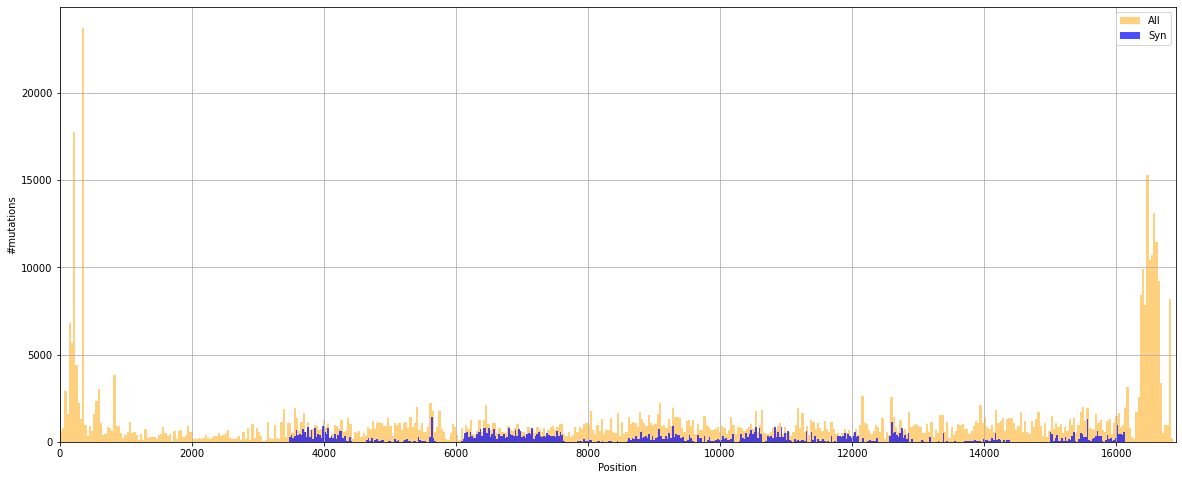

In [69]:
plt.figure(figsize=(20, 8))
mut.position.hist(bins=500, alpha=0.5, label="All", color="orange")
muts_filtered.position.hist(bins=500, alpha=0.7, label="Syn", color="b")
# plt.yscale("log")
plt.xlim(0, 16900)
plt.xlabel("Position")
plt.ylabel("#mutations")
plt.legend()
plt.show()

In [12]:
muts_filtered.pos_in_codon.value_counts()

3.0    96293
1.0     6988
Name: pos_in_codon, dtype: int64

In [13]:
muts_filtered.is_leaf.value_counts()

1    62571
0    40710
Name: is_leaf, dtype: int64

In [72]:
muts_filtered.derived_aa.value_counts()

Leu     20609
Ser      8783
Pro      7976
Gly      6512
Ala      5814
Stop     5651
Thr      5430
Tyr      4562
Glu      4553
Ile      4298
His      4242
Met      4019
Val      3659
Trp      3281
Gln      3185
Asn      2981
Lys      2759
Phe      2676
Asp      1095
Arg       701
Cys       495
Name: derived_aa, dtype: int64

In [75]:
muts_filtered.gene_info.value_counts()

mRNA_COX1         26077
mRNA_ND1          15622
mRNA_CYTB         12685
mRNA_ND5           9446
mRNA_ND4           9106
mRNA_ATP6          8186
mRNA_ND3           6142
mRNA_ND4L          4731
mRNA_COX3          4441
mRNA_ND2           4322
mRNA_ATP8          1188
mRNA_COX2           917
mRNA_ATP8&ATP6      414
mRNA_ND4L&ND4         4
Name: gene_info, dtype: int64

In [76]:
muts_filtered.Mut.value_counts().head(10)

A[G>A]C    4392
C[T>C]T    4324
A[A>G]C    4225
C[C>T]T    4062
A[T>C]T    4009
A[C>T]T    3726
C[G>A]C    3199
T[G>A]C    3122
T[A>G]C    2993
C[A>G]C    2976
Name: Mut, dtype: int64

In [77]:
muts_filtered.Mut.value_counts().tail(10)

C[G>C]G    4
G[C>G]T    4
G[A>T]A    4
G[G>C]T    4
T[C>G]G    4
G[T>G]A    4
G[G>C]C    4
G[T>A]A    2
G[A>T]T    2
G[T>A]T    2
Name: Mut, dtype: int64

## Load saved filtered mutations

In [2]:
muts_filtered = pd.read_csv("../data/interim/mutations_syn.csv")
muts_filtered["Label"] = 1
muts_filtered_leaves = muts_filtered[muts_filtered.is_leaf == 1]
muts_filtered.head(2)

,first,second,position,ref_pos,ancestor,descendant,nuc_ref_in_ali,gene_info,gene_start,pos_in_codon,...,note,is_leaf,is_cds,Mut,ref_cdn,alt_cdn,ref_aa,alt_aa,IsSyn,Label
0,17837,EU_IT_0648,3642,3482,gaAcc,gaGcc,G,mRNA_ND1,3306.0,3.0,...,normal,1,1,A[A>G]C,GAA,GAG,E,E,1,1
1,6484,EU_GB_0203,8826,8598,ttTta,ttCta,C,mRNA_ATP6,8526.0,3.0,...,normal,1,1,T[T>C]T,TTT,TTC,F,F,1,1


## Load refseq

In [3]:
# Read reference genbank
path_to_ref = "../data/processed/ref_annot.csv"
Ref = pd.read_csv(path_to_ref)
prot_ref = Ref[(Ref.Type == "CDS") & (Ref.Strand == 1)]

print(prot_ref.shape)
prot_ref.head(4000)

(10816, 10)


,Pos,Nuc,Context,Strand,Type,GeneName,PosInGene,PosInCodon,Codon,TBSS
3306,3307,A,CAT,1,CDS,ND1,1,1,ATA,11741.0
3307,3308,T,ATA,1,CDS,ND1,2,2,ATA,11743.0
3308,3309,A,TAC,1,CDS,ND1,3,3,ATA,11745.0
3309,3310,C,ACC,1,CDS,ND1,4,1,CCC,11747.0
3310,3311,C,CCC,1,CDS,ND1,5,2,CCC,11749.0
...,...,...,...,...,...,...,...,...,...,...
8040,8041,A,TAA,1,CDS,COX2,456,3,ATA,4486.0
8041,8042,A,AAT,1,CDS,COX2,457,1,ATA,4488.0
8042,8043,T,ATA,1,CDS,COX2,458,2,ATA,4490.0
8043,8044,A,TAA,1,CDS,COX2,459,3,ATA,4492.0


## Calculate expected mutations for Human mtDNA (all, syn, genes)

In [34]:
exp_muts12 = dict()
exp_muts192 = dict()
for gene, gtable in prot_ref[prot_ref.Codon.str.len() == 3].groupby("GeneName"):
    assert np.all(gtable.PosInGene == np.arange(1, gtable.shape[0] + 1))
    seq = gtable.Nuc.values
    gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=["syn"])
    for lbl in gene_exp_muts12:
        if lbl not in exp_muts12:
            exp_muts12[lbl] = defaultdict(int)
            exp_muts192[lbl] = defaultdict(int)

        for sbs, _cnt in gene_exp_muts12[lbl].items():
            exp_muts12[lbl][sbs] += _cnt
        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[lbl][sbs] += _cnt

        # if lbl == "syn":
        #     exp_muts12[lbl + "_" + gene] = gene_exp_muts12[lbl]
        #     exp_muts192[lbl + "_" + gene] = gene_exp_muts192[lbl]

for lbl in ["D-loop", "rRNA", "tRNA"]:
    f1, f2 = coda.collect_exp_mut_freqs(Ref[Ref.Type == lbl]["Nuc"].values, labels=["all"])
    exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

lbl = "ExDloop"
f1, f2 = coda.collect_exp_mut_freqs(Ref[(~Ref.Type.isin(["D-loop", "misc_feature"]))]["Nuc"].values, labels=["all"])
exp_muts12[lbl], exp_muts192[lbl] = f1["all"], f2["all"]

In [35]:
pd.DataFrame(exp_muts12).sort_index()

,syn,D-loop,rRNA,tRNA,ExDloop
A>C,766,339,861,527,4785
A>G,1308,339,861,527,4785
A>T,766,339,861,527,4785
C>A,817,371,650,353,4810
C>G,817,371,650,353,4810
C>T,1872,371,650,353,4810
G>A,178,150,451,217,2015
G>C,96,150,451,217,2015
G>T,96,150,451,217,2015
T>A,261,260,548,405,3834


In [16]:
pd.DataFrame(exp_muts192).sort_index()

,syn,D-loop,rRNA,tRNA,ExDloop
A[A>C]A,NaN,30,113,78.0,494
A[A>C]C,NaN,32,84,51.0,463
A[A>C]G,NaN,13,69,40.0,196
A[A>C]T,NaN,21,50,41.0,355
A[A>G]A,78.0,30,113,78.0,494
...,...,...,...,...,...
T[T>C]T,47.0,20,32,44.0,231
T[T>G]A,34.0,18,56,52.0,311
T[T>G]C,28.0,15,26,27.0,293
T[T>G]G,11.0,12,22,14.0,104


## Calculate MutSpec

### D-loop

In [17]:
ms12dloop  = calculate_mutspec(muts_dloop, exp_muts12["D-loop"], use_context=False)
ms192dloop = calculate_mutspec(muts_dloop, exp_muts192["D-loop"], use_context=True)

In [19]:
ms12dloop

,Mut,ObsNum,ExpNum,RawMutSpec,MutSpec
0,A>C,2993,339,8.828909,0.017958
1,A>G,17870,339,52.713864,0.107221
2,A>T,695,339,2.050147,0.004170
3,C>A,2803,371,7.555256,0.015368
4,C>G,408,371,1.099730,0.002237
5,C>T,42530,371,114.636119,0.233172
6,G>A,18638,150,124.253333,0.252734
7,G>C,377,150,2.513333,0.005112
8,G>T,205,150,1.366667,0.002780
9,T>A,654,260,2.515385,0.005116


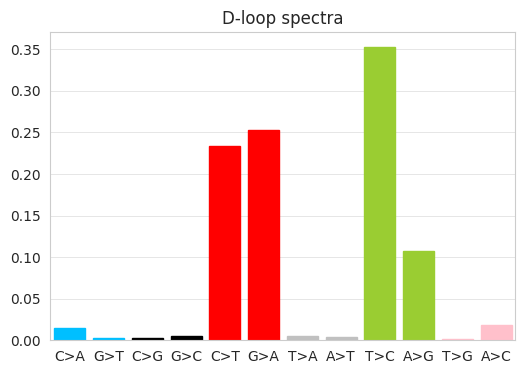

<AxesSubplot:title={'center':'D-loop spectra'}>

In [18]:
plot_mutspec12(ms12dloop, title="D-loop spectra");

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


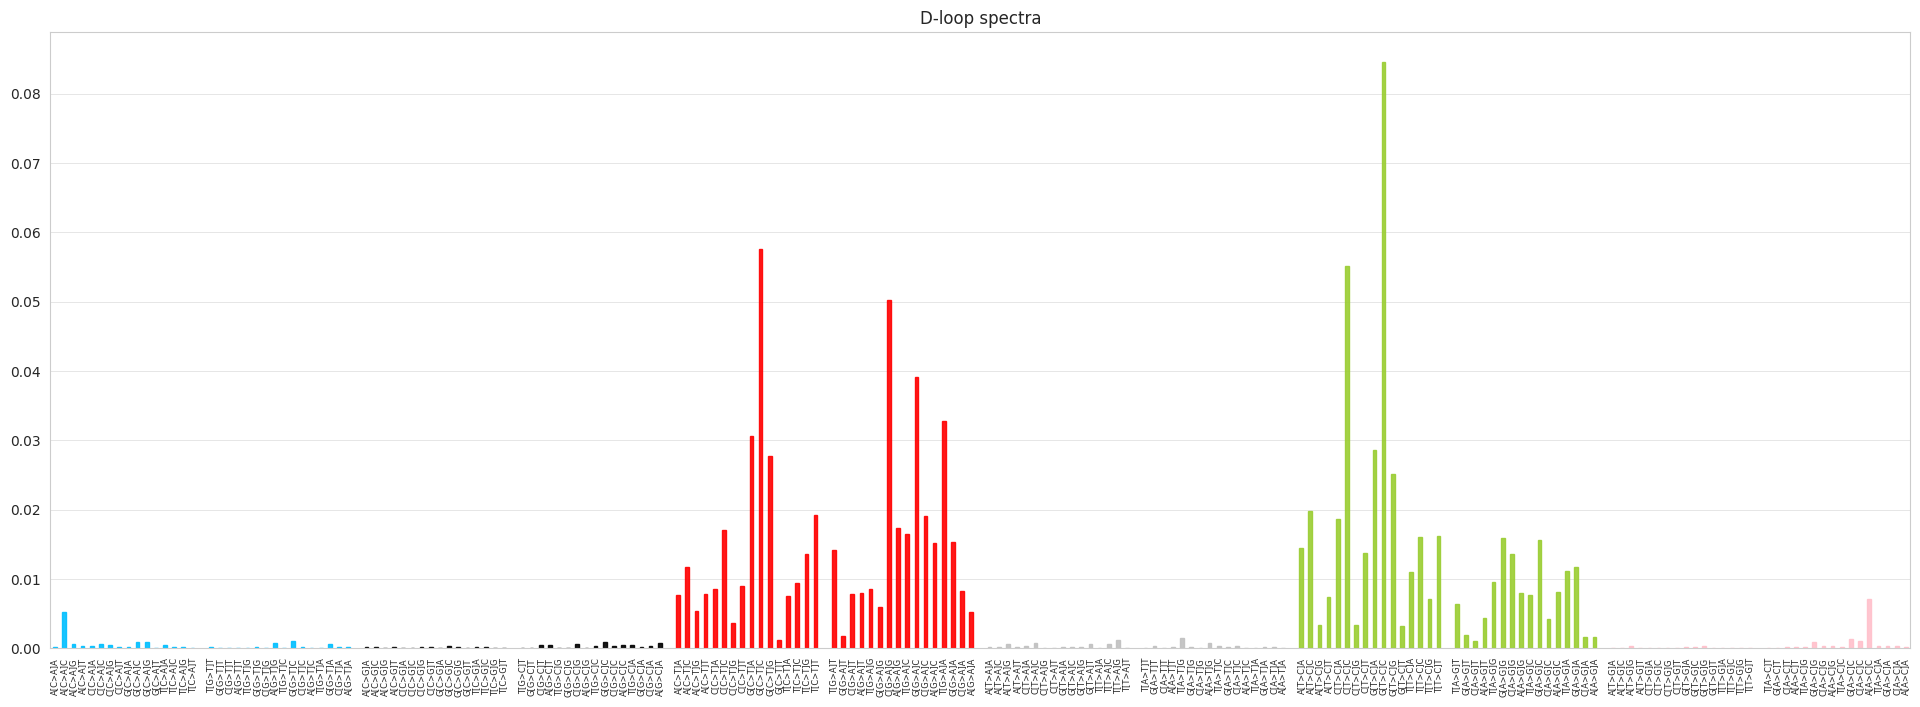

In [20]:
plot_mutspec192(ms192dloop, title="D-loop spectra");

### Full tree

In [7]:
muts_filtered["Label"] = 1
ms192 = calculate_mutspec(muts_filtered, exp_muts192["syn"], use_context=True)
ms12 = calculate_mutspec(muts_filtered, exp_muts12["syn"], use_context=False)

# Reverse complement of Mut (to heavy strand) is unneded
# ms192["Mut"] = ms192.Mut.apply(rev_comp)
# ms12["Mut"] = ms12.Mut.str.translate(translator)
ms192.sort_values("Mut", inplace=True)
ms12.sort_values("Mut", inplace=True)

ms12.to_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn.csv", index=None)
ms192.to_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn.csv", index=None)

In [8]:
ms12 = pd.read_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn.csv")
ms192 = pd.read_csv("../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn.csv")

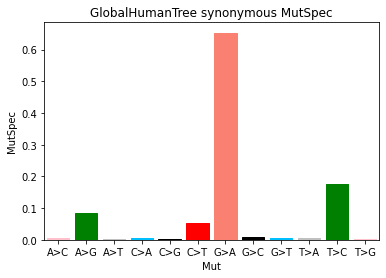

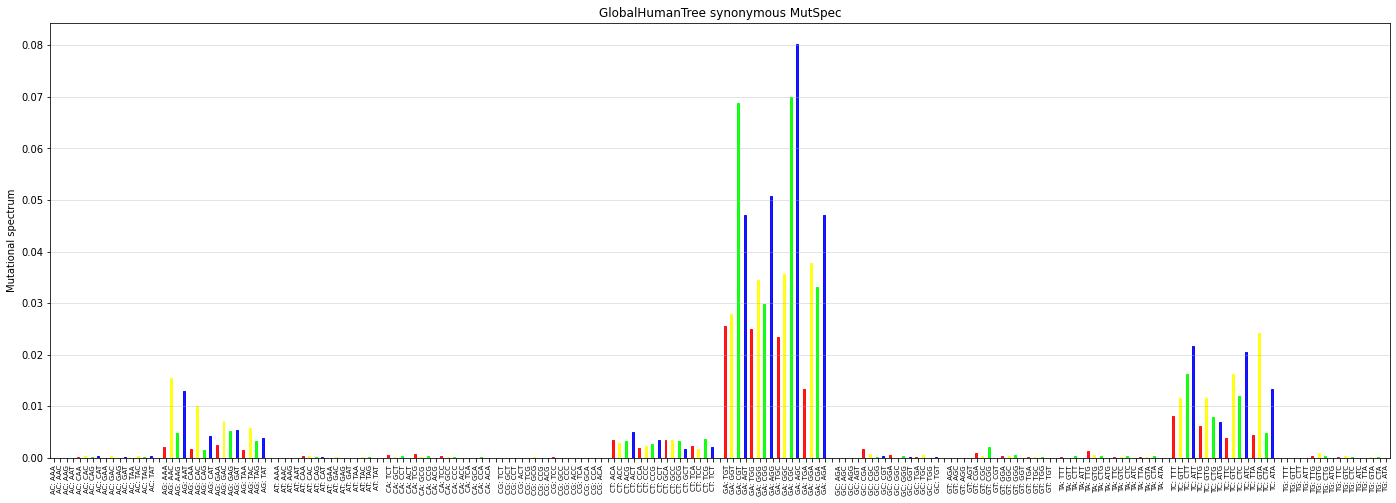

In [13]:
plot_mutspec12(ms12, title="GlobalHumanTree synonymous MutSpec",   savepath="../data/mutspecs_human_global_tree/human_global_tree_mutspec12syn.pdf")
plot_mutspec192kk(ms192, title="GlobalHumanTree synonymous MutSpec", filepath="../data/mutspecs_human_global_tree/human_global_tree_mutspec192syn.pdf")

### Only leaves

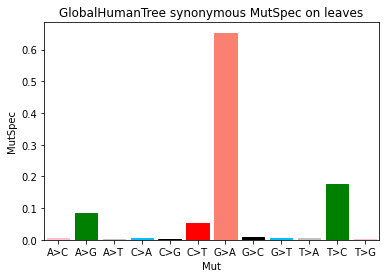

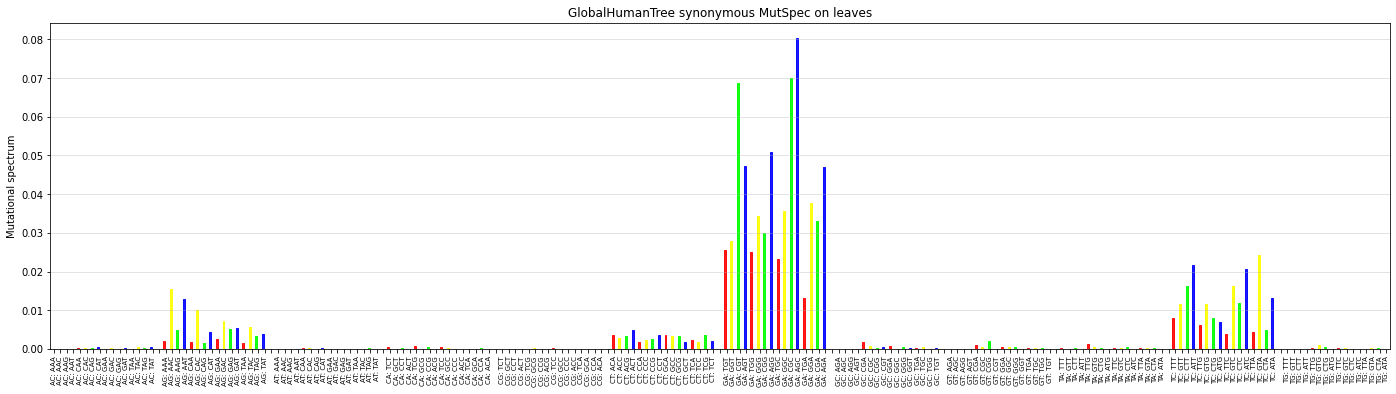

In [7]:
ms12 = calculate_mutspec(muts_filtered_leaves, exp_muts12["syn"], use_context=False)
ms192 = calculate_mutspec(muts_filtered_leaves, exp_muts192["syn"], use_context=True)

# Reverse complement of Mut (to heavy strand)
# ms192["Mut"] = ms192.Mut.apply(rev_comp)
# ms12["Mut"] = ms12.Mut.str.translate(translator)
ms12.sort_values("Mut", inplace=True)
ms192.sort_values("Mut", inplace=True)

ms12.to_csv( "../data/GlobalHumanTree/mutspec12syn_leaves.csv", index=None)
ms192.to_csv("../data/GlobalHumanTree/mutspec192syn_leaves.csv", index=None)

plot_mutspec12(ms12,   title="GlobalHumanTree synonymous MutSpec on leaves", savepath="../figures/GlobalHumanTree/mutspec12syn_leaves.pdf")
plot_mutspec192kk(ms192, title="GlobalHumanTree synonymous MutSpec on leaves", filepath="../figures/GlobalHumanTree/mutspec192syn_leaves.pdf")

## TSSS

Comparison of the 6-8 and 14-16 in GlobalTree (where differences are significant). This is where Bogdan’s confirmation is most needed. 

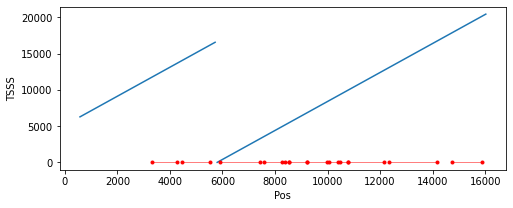

In [4]:
plt.figure(figsize=(8, 3))
plt.plot(Ref.Pos, Ref.TBSS)
for gn in prot_ref.GeneName.unique():
    pmin = prot_ref[prot_ref.GeneName == gn].Pos.min()
    pmax = prot_ref[prot_ref.GeneName == gn].Pos.max()
    plt.plot([pmin, pmax], [0, 0], "r.-", linewidth=0.5)
plt.ylabel("TSSS")
plt.xlabel("Pos")
plt.show()

In [10]:
prot_ref.groupby("GeneName").Pos\
    .apply(lambda x: {"min": x.min(), "max": x.max(), "len": x.max()-x.min()})\
        .reset_index()\
            .pivot(index='GeneName', columns="level_1")\
                .sort_values(("Pos", "min"))

Pos              
level_1    len    max    min
GeneName                    
ND1        955   4262   3307
ND2       1041   5511   4470
COX1      1541   7445   5904
COX2       683   8269   7586
ATP8       160   8526   8366
ATP6       679   9206   8527
COX3       783   9990   9207
ND3        345  10404  10059
ND4L       289  10759  10470
ND4       1377  12137  10760
ND5       1811  14148  12337
CYTB      1140  15887  14747

In [4]:
def get_exp_mut_freqs(pos_min, pos_max, ref=prot_ref, lbl="syn", verbose=True):
    _pic_col_idx = list(ref.columns).index("PosInCodon")
    cur_ref = ref[(ref.Pos >= pos_min) & (ref.Pos <= pos_max)]
    if len(cur_ref) < 10:
        return None, None
    if lbl == "syn":
        pic_first = cur_ref.iloc[0].PosInCodon
        pic_last  = cur_ref.iloc[-1].PosInCodon
        pos_min = cur_ref.Pos.min() - pic_first + 1
        pos_max = cur_ref.Pos.max() + 3 - pic_last
    if verbose:
        print(f"Adjusted positions: {pos_min}-{pos_max}")
    cur_ref = ref[(ref.Pos >= pos_min) & (ref.Pos <= pos_max)]
    # return cur_ref
    # assert cur_ref.iloc[0].PosInCodon == 1
    # assert cur_ref.iloc[-1].PosInCodon == 3

    exp_muts12, exp_muts192 = defaultdict(int), defaultdict(int)
    for gn, df in cur_ref.groupby("GeneName"):
        seq = df.Nuc.values
        gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=[lbl])

        for sbs, _cnt in gene_exp_muts12[lbl].items():
            exp_muts12[sbs] += _cnt
        for sbs, _cnt in gene_exp_muts192[lbl].items():
            exp_muts192[sbs] += _cnt
    
    return exp_muts12, exp_muts192

### 6-8k

Adjusted positions: 6000-8002
Number of mutations: 15378


WARNING! Substitution A[G>A]A is unexpected but observed, n=16
WARNING! Substitution G[G>A]C is unexpected but observed, n=61
WARNING! Substitution G[G>T]C is unexpected but observed, n=4


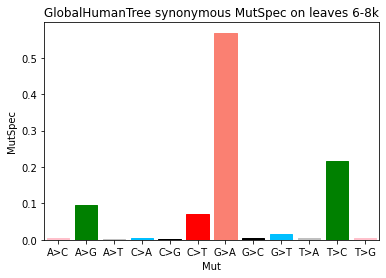

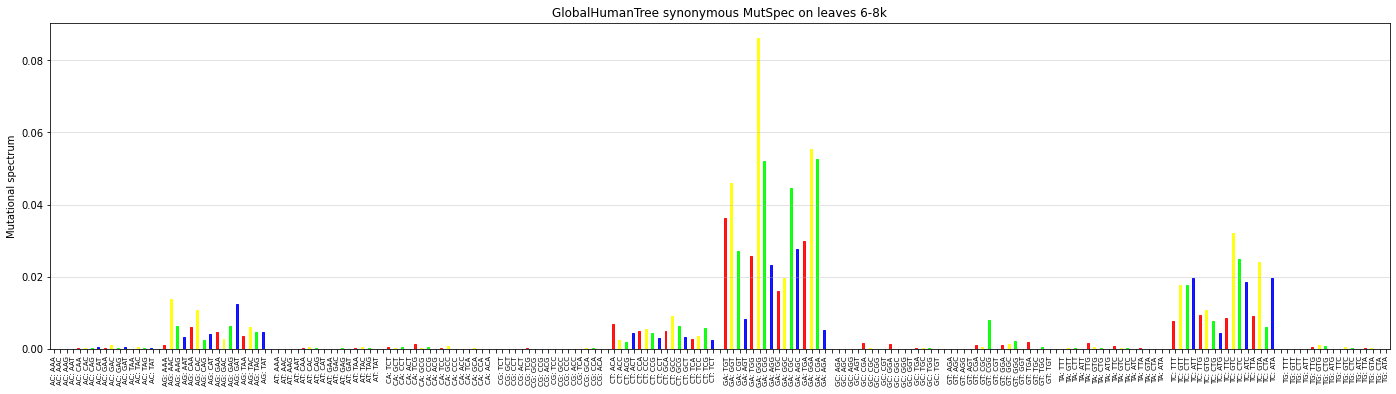

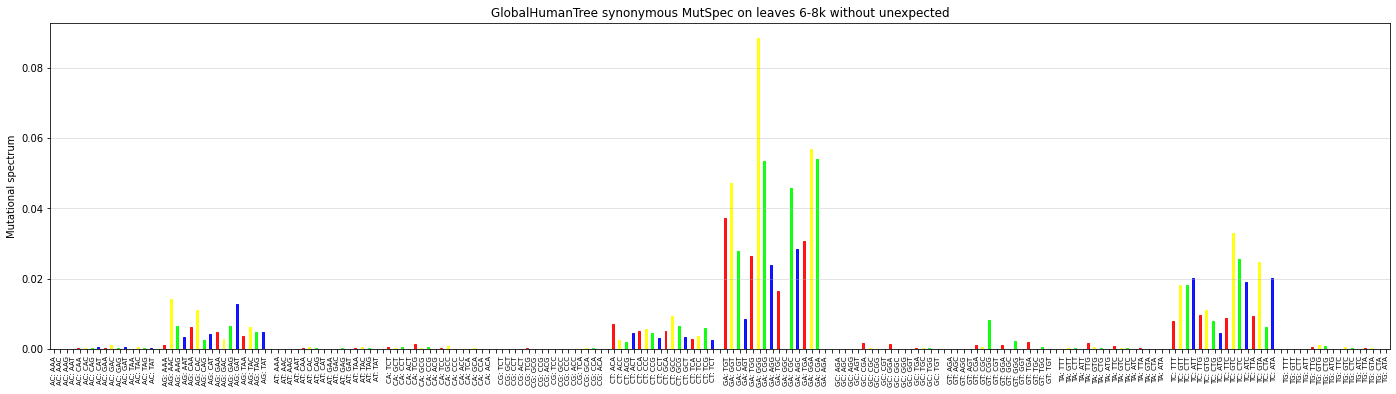

In [40]:
pmin, pmax = 6000, 8000

exp_muts12, exp_muts192 = get_exp_mut_freqs(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered_leaves[(muts_filtered_leaves.ref_pos >= pmin) & (muts_filtered_leaves.ref_pos <= pmax)]
print("Number of mutations:", obs_muts.shape[0])
ms12 = calculate_mutspec(obs_muts, exp_muts12, verbose=True)
ms192 = calculate_mutspec(obs_muts, exp_muts192, use_context=True, verbose=True)

ms12.to_csv(f"../data/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)
ms192.to_csv(f"../data/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)

plot_mutspec12(ms12, title=f"GlobalHumanTree synonymous MutSpec on leaves {pmin//1000}-{pmax//1000}k", 
    savepath=f"../figures/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.pdf")
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec on leaves {pmin//1000}-{pmax//1000}k", 
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.pdf")

ms192["RawMutSpec"] = (ms192["ObsNum"] / ms192["ExpFr"]).fillna(0).replace(np.inf, 0)
ms192["MutSpec"] = ms192["RawMutSpec"] / ms192["RawMutSpec"].sum()
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec on leaves {pmin//1000}-{pmax//1000}k without unexpected",
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k_without_unexpected.pdf")

### 14-16k

Adjusted positions: 13999-15889
Number of mutations: 8015


WARNING! Substitution A[G>A]A is unexpected but observed, n=183
WARNING! Substitution A[G>A]G is unexpected but observed, n=133
WARNING! Substitution A[G>A]T is unexpected but observed, n=232
WARNING! Substitution A[T>C]C is unexpected but observed, n=120
WARNING! Substitution C[G>A]A is unexpected but observed, n=30
WARNING! Substitution C[G>A]C is unexpected but observed, n=301
WARNING! Substitution C[G>C]A is unexpected but observed, n=5
WARNING! Substitution C[G>T]A is unexpected but observed, n=8
WARNING! Substitution C[G>T]C is unexpected but observed, n=6
WARNING! Substitution C[T>A]G is unexpected but observed, n=3
WARNING! Substitution C[T>C]G is unexpected but observed, n=28
WARNING! Substitution G[G>A]T is unexpected but observed, n=21
WARNING! Substitution G[T>C]T is unexpected but observed, n=2
WARNING! Substitution T[G>A]G is unexpected but observed, n=27
WARNING! Substitution T[G>A]T is unexpected but observed, n=63


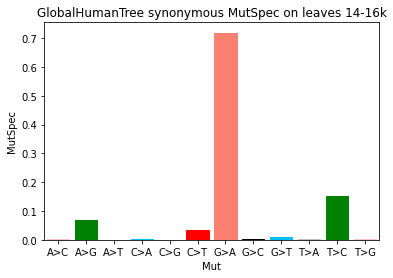

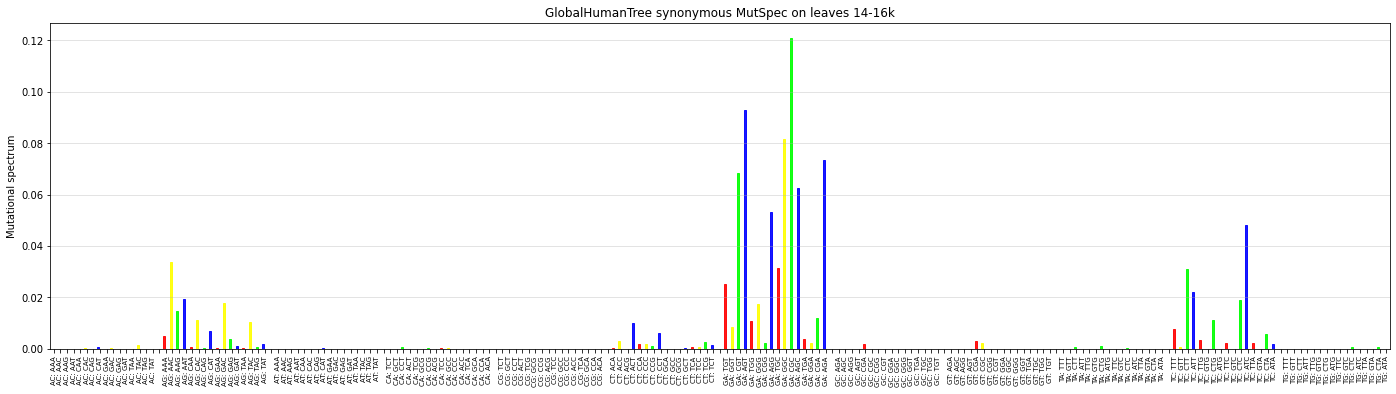

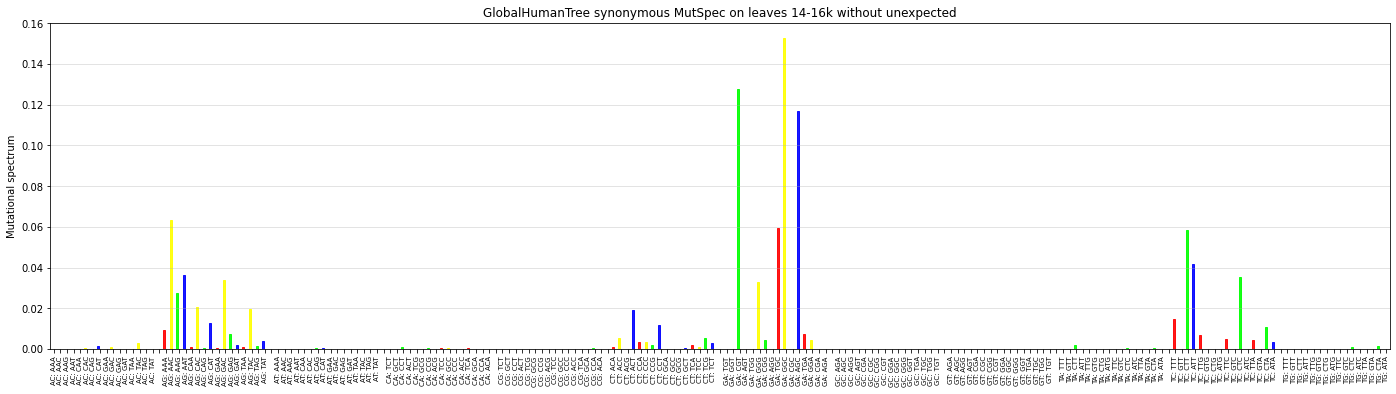

In [41]:
pmin, pmax = 14000, 16000

exp_muts12, exp_muts192 = get_exp_mut_freqs(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered_leaves[(muts_filtered_leaves.ref_pos >= pmin) & (muts_filtered_leaves.ref_pos <= pmax)]
print("Number of mutations:", obs_muts.shape[0])
ms12 = calculate_mutspec(obs_muts, exp_muts12, verbose=True)
ms192 = calculate_mutspec(obs_muts, exp_muts192, use_context=True, verbose=True)

ms12.to_csv(f"../data/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)
ms192.to_csv(f"../data/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.csv", index=None)

plot_mutspec12(ms12, title=f"GlobalHumanTree synonymous MutSpec on leaves {pmin//1000}-{pmax//1000}k", 
    savepath=f"../figures/GlobalHumanTree/mutspec12syn_leaves{pmin//1000}-{pmax//1000}k.pdf")
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec on leaves {pmin//1000}-{pmax//1000}k", 
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.pdf")

ms192["RawMutSpec"] = (ms192["ObsNum"] / ms192["ExpFr"]).fillna(0).replace(np.inf, 0)
ms192["MutSpec"] = ms192["RawMutSpec"] / ms192["RawMutSpec"].sum()
plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec on leaves {pmin//1000}-{pmax//1000}k without unexpected",
    filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k_without_unexpected.pdf")

Adjusted positions: 8000-9992
Number of mutations: 8721


WARNING! Substitution A[G>A]G is unexpected but observed, n=236
WARNING! Substitution C[G>A]T is unexpected but observed, n=252
WARNING! Substitution C[G>C]T is unexpected but observed, n=6


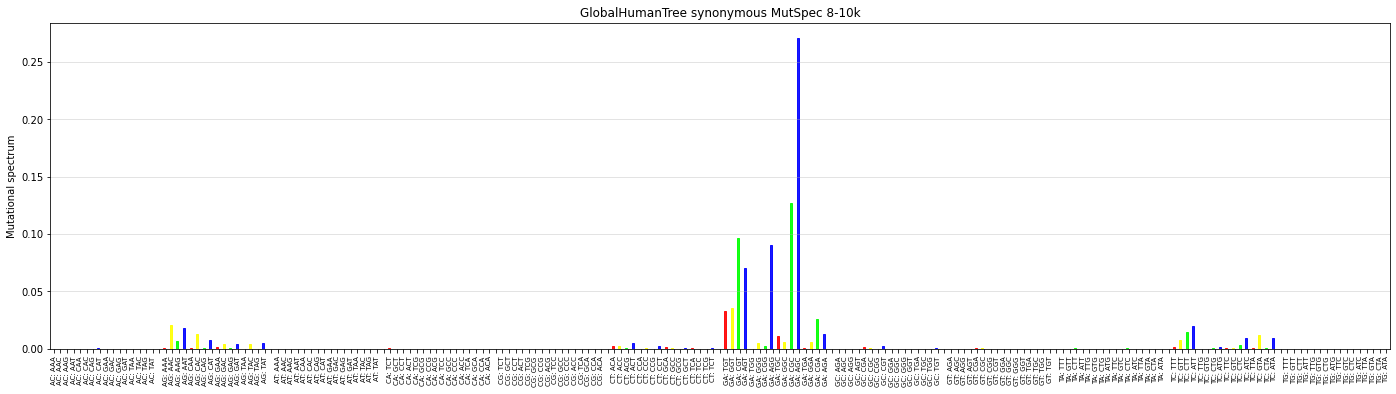

In [42]:
pmin, pmax = 8000, 10000

_, exp_muts192 = get_exp_mut_freqs(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered[(muts_filtered.ref_pos >= pmin) & (muts_filtered_leaves.ref_pos <= pmax)]
print("Number of mutations:", obs_muts.shape[0])
ms192 = calculate_mutspec(obs_muts, exp_muts192, use_context=True, verbose=True)

plot_mutspec192kk(ms192, title=f"GlobalHumanTree synonymous MutSpec {pmin//1000}-{pmax//1000}k", )
    # filepath=f"../figures/GlobalHumanTree/mutspec192syn_leaves{pmin//1000}-{pmax//1000}k.pdf")

## Distributions on genes/intervals

In [37]:
muts_filtered["TBSS"] = muts_filtered.ref_pos.map(prot_ref.set_index("Pos").TBSS.to_dict())
muts_filtered_leaves["TBSS"] = muts_filtered_leaves.ref_pos.map(prot_ref.set_index("Pos").TBSS.to_dict())

### genes


In [38]:
lbl = "syn"
exp_muts12syn = dict()
exp_muts192syn = dict()
for gene, gtable in prot_ref[prot_ref.Codon.str.len() == 3].groupby("GeneName"):
    assert np.all(gtable.PosInGene == np.arange(1, gtable.shape[0] + 1))
    seq = gtable.Nuc.values
    gene_exp_muts12, gene_exp_muts192 = coda.collect_exp_mut_freqs(seq, labels=[lbl])

    exp_muts12syn[gene] = gene_exp_muts12[lbl]
    exp_muts192syn[gene] = gene_exp_muts192[lbl]

In [39]:
exp_muts192syn["COX2&ATP6&8"] = dict()
exp_muts192syn["COX3&ND3&4L"] = dict()

exp_muts12syn["COX2&ATP6&8"] = dict()
exp_muts12syn["COX3&ND3&4L"] = dict()

for sbs in possible_sbs12:
    count = exp_muts12syn["ATP6"][sbs] + exp_muts12syn["ATP8"][sbs] + exp_muts12syn["COX2"][sbs]
    if count > 0:
        exp_muts12syn["COX2&ATP6&8"][sbs] = count

    count = exp_muts12syn["ND3"][sbs] + exp_muts12syn["ND4L"][sbs] + exp_muts12syn["COX3"][sbs]
    if count > 0:
        exp_muts12syn["COX3&ND3&4L"][sbs] = count

for sbs in possible_sbs192:
    count = exp_muts192syn["ATP6"][sbs] + exp_muts192syn["ATP8"][sbs] + exp_muts192syn["COX2"][sbs]
    if count > 0:
        exp_muts192syn["COX2&ATP6&8"][sbs] = count

    count = exp_muts192syn["ND3"][sbs] + exp_muts192syn["ND4L"][sbs] + exp_muts192syn["COX3"][sbs]
    if count > 0:
        exp_muts192syn["COX3&ND3&4L"][sbs] = count

In [40]:
pd.DataFrame(exp_muts12syn)

,ATP6,ATP8,COX1,COX2,COX3,CYTB,ND1,ND2,ND3,ND4,ND4L,ND5,COX2&ATP6&8,COX3&ND3&4L
G>A,14,3,27,16,18,14,17,19,5,17,6,22,33,29
C>T,118,23,253,108,124,208,179,174,57,247,52,329,249,233
A>G,79,23,184,75,92,138,117,127,48,176,36,213,177,176
T>C,46,8,93,48,48,55,42,65,27,73,17,101,102,92
G>T,8,0,15,8,10,7,9,11,2,10,5,11,16,17
G>C,8,0,15,8,10,7,9,11,2,10,5,11,16,17
T>A,21,3,48,23,12,16,16,30,7,32,4,49,47,23
T>G,21,3,48,23,12,16,16,30,7,32,4,49,47,23
A>C,49,9,115,42,55,88,70,64,19,104,24,127,100,98
A>T,49,9,115,42,55,88,70,64,19,104,24,127,100,98


In [41]:
gmutspecs192 = []
gmutspecs12 = []
for gname in prot_ref.GeneName.unique():
    obs_muts = muts_filtered[(muts_filtered.gene_info == "mRNA_" + gname)]
    tbss_mean = obs_muts.TBSS.mean()
    print(f"{gname}:\t{obs_muts.shape[0]} muts,\tmean TSSS: {tbss_mean:.2f}")

    ms192 = calculate_mutspec(obs_muts, exp_muts192syn[gname], use_context=True)
    ms12 = calculate_mutspec(obs_muts, exp_muts12syn[gname], use_context=False)
    ms12 = ms12[ms12.ObsNum > 0]
    ms192 = ms192[ms192.ObsNum > 0]
    # # don't use unexpected mutations
    # ms192["RawMutSpec"] = np.where((ms192.ObsNum > 0) & (ms192.ExpFr == 0), 0, ms192.RawMutSpec)
    # ms192["MutSpec"] = ms192["RawMutSpec"] / ms192["RawMutSpec"].sum()
    # ms12 = ms12[ms12.ExpFr > 0]
    # ms192 = ms192[ms192.ExpFr > 0]

    ms192["TBSS"] = tbss_mean
    ms192["GeneName"] = gname
    ms12["TBSS"] = tbss_mean
    ms12["GeneName"] = gname

    gmutspecs12.append(ms12)
    gmutspecs192.append(ms192)

gname = "COX2&ATP6&8"
obs_muts = muts_filtered[(muts_filtered.gene_info.isin(["mRNA_ATP6", "mRNA_ATP8", "mRNA_COX2"]))]
tbss_mean = obs_muts.TBSS.mean()
print(f"{gname}:\t{obs_muts.shape[0]} muts,\tmean TSSS: {tbss_mean:.2f}")

ms192 = calculate_mutspec(obs_muts, exp_muts192syn[gname], use_context=True)
ms12 = calculate_mutspec(obs_muts, exp_muts12syn[gname], use_context=False)
ms12 = ms12[ms12.ObsNum > 0]
ms192 = ms192[ms192.ObsNum > 0]

ms192["TBSS"] = tbss_mean
ms192["GeneName"] = gname
ms12["TBSS"] = tbss_mean
ms12["GeneName"] = gname

gmutspecs12.append(ms12)
gmutspecs192.append(ms192)

gname = "COX3&ND3&4L"
obs_muts = muts_filtered[(muts_filtered.gene_info.isin(["mRNA_ND3", "mRNA_ND4L", "mRNA_COX3"]))]
tbss_mean = obs_muts.TBSS.mean()
print(f"{gname}:\t{obs_muts.shape[0]} muts,\tmean TSSS: {tbss_mean:.2f}")

ms192 = calculate_mutspec(obs_muts, exp_muts192syn[gname], use_context=True)
ms12 = calculate_mutspec(obs_muts, exp_muts12syn[gname], use_context=False)
ms12 = ms12[ms12.ObsNum > 0]
ms192 = ms192[ms192.ObsNum > 0]

ms192["TBSS"] = tbss_mean
ms192["GeneName"] = gname
ms12["TBSS"] = tbss_mean
ms12["GeneName"] = gname

gmutspecs12.append(ms12)
gmutspecs192.append(ms192)

full_ms192 = pd.concat(gmutspecs192)
full_ms12 = pd.concat(gmutspecs12)

ND1:	15622 muts,	mean TSSS: 12626.62
ND2:	4322 muts,	mean TSSS: 15402.80
COX1:	26077 muts,	mean TSSS: 1710.21
COX2:	917 muts,	mean TSSS: 4131.14
ATP8:	1188 muts,	mean TSSS: 5322.04
ATP6:	8186 muts,	mean TSSS: 6217.98
COX3:	4441 muts,	mean TSSS: 7647.23
ND3:	6142 muts,	mean TSSS: 8926.05
ND4L:	4731 muts,	mean TSSS: 9661.99
ND4:	9106 muts,	mean TSSS: 11348.36
ND5:	9446 muts,	mean TSSS: 14211.97
CYTB:	12685 muts,	mean TSSS: 19131.64
COX2&ATP6&8:	10291 muts,	mean TSSS: 5928.60
COX3&ND3&4L:	15314 muts,	mean TSSS: 8782.55


### Asymmetry

#### Genes-split

In [42]:
from pymutspec.annotation import transcriptor, rev_comp

In [43]:
gs192 = full_ms192[(full_ms192.ObsNum >= 2) & (full_ms192.ExpNum >= 2) &
    (~full_ms192.GeneName.isin(["ND1", "ND2", "ND3", "ND4L", "ATP6", "ATP8", "COX2", "COX3"]))
]
gs192["Mut"] = gs192["Mut"].apply(rev_comp)  # to heavy chain

gs192["Cxt"] = gs192.Mut.str.get(0) + gs192.Mut.str.get(2) + gs192.Mut.str.get(-1)
gs192["MutBase"] = gs192.Mut.str.slice(2, 5)

gs192.GeneName.value_counts()

COX1           105
COX3&ND3&4L     87
ND4             80
COX2&ATP6&8     74
ND5             72
CYTB            65
Name: GeneName, dtype: int64

In [44]:
prot_ref.groupby("GeneName").Pos\
    .apply(lambda x: {"min": x.min(), "max": x.max(), "len": x.max()-x.min()})\
        .reset_index()\
            .pivot(index='GeneName', columns="level_1")\
                .sort_values(("Pos", "min"))

Pos              
level_1    len    max    min
GeneName                    
ND1        955   4262   3307
ND2       1041   5511   4470
COX1      1541   7445   5904
COX2       683   8269   7586
ATP8       160   8526   8366
ATP6       679   9206   8527
COX3       783   9990   9207
ND3        345  10404  10059
ND4L       289  10759  10470
ND4       1377  12137  10760
ND5       1811  14148  12337
CYTB      1140  15887  14747

In [45]:
assymetry = pd.read_table(
    'https://raw.githubusercontent.com/mitoclub/mtdna-192component-mutspec-chordata/main/data/external/T-R_plot_allCpG.txt', 
    sep='\s', header=None, names=['Cxt','MutBase','T','R'])

In [46]:
gs192_forvard = gs192[gs192.MutBase.isin(assymetry.MutBase.unique())]

gs192_reverse = gs192[~gs192.MutBase.isin(assymetry.MutBase.unique())]
gs192_reverse["Mut"] = gs192_reverse["Mut"].apply(rev_comp)

In [50]:
ass = gs192_forvard.merge(gs192_reverse[["Mut", "GeneName", "ObsNum", "ExpNum", "MutSpec"]], on=["GeneName", "Mut"])
ass["Asymmetry"] = ass.MutSpec_x / ass.MutSpec_y

In [51]:
# ass.to_csv("../data/processed/HGT_asymmentry.csv", index=False)
ass = pd.read_csv("../data/processed/HGT_asymmentry.csv")
ass["TBSS"] = ass["TBSS"].astype(int)
ass

,Mut,ObsNum_x,ExpNum_x,RawMutSpec,MutSpec_x,TBSS,GeneName,Cxt,MutBase,ObsNum_y,ExpNum_y,MutSpec_y,Asymmetry
0,T[T>C]T,32,4.0,8.000000,0.001202,1710,COX1,TTT,T>C,347,6.0,0.008691,0.138329
1,G[T>C]T,521,6.0,86.833333,0.013050,1710,COX1,GTT,T>C,212,3.0,0.010620,1.228774
2,C[T>C]T,325,8.0,40.625000,0.006105,1710,COX1,CTT,T>C,720,7.0,0.015458,0.394965
3,A[T>C]T,64,3.0,21.333333,0.003206,1710,COX1,ATT,T>C,705,6.0,0.017658,0.181560
4,G[C>T]T,528,3.0,176.000000,0.026450,1710,COX1,GCT,C>T,193,9.0,0.003223,8.207254
...,...,...,...,...,...,...,...,...,...,...,...,...,...
117,C[T>A]A,3,18.0,0.166667,0.000065,8782,COX3&ND3&4L,CTA,T>A,5,7.0,0.000278,0.233333
118,T[C>T]A,135,2.0,67.500000,0.026312,8782,COX3&ND3&4L,TCA,C>T,311,16.0,0.007577,3.472669
119,G[C>T]A,784,4.0,196.000000,0.076401,8782,COX3&ND3&4L,GCA,C>T,6,3.0,0.000780,98.000000
120,C[C>T]A,376,4.0,94.000000,0.036641,8782,COX3&ND3&4L,CCA,C>T,191,16.0,0.004653,7.874346


In [56]:
ass[ass.Asymmetry > 10]

,Mut,ObsNum_x,ExpNum_x,RawMutSpec,MutSpec_x,TBSS,GeneName,Cxt,MutBase,ObsNum_y,ExpNum_y,MutSpec_y,Asymmetry
48,G[C>T]A,201,2.0,100.500000,0.037501,11348,ND4,GCA,C>T,49,6.0,0.003047,12.306122
55,G[C>T]T,1145,3.0,381.666667,0.175267,14211,ND5,GCT,C>T,40,7.0,0.002624,66.791667
59,T[C>T]G,102,2.0,51.000000,0.023420,14211,ND5,TCG,C>T,24,15.0,0.000735,31.875000
86,G[C>T]T,738,2.0,369.000000,0.115880,5928,COX2&ATP6&8,GCT,C>T,28,5.0,0.001759,65.892857
88,T[T>C]G,73,15.0,4.866667,0.001528,5928,COX2&ATP6&8,TTG,T>C,2,8.0,0.000079,19.466667
119,G[C>T]A,784,4.0,196.000000,0.076401,8782,COX3&ND3&4L,GCA,C>T,6,3.0,0.000780,98.000000


In [52]:
ass[["TBSS", "GeneName"]].drop_duplicates()

,TBSS,GeneName
0,1710,COX1
33,11348,ND4
51,14211,ND5
72,19131,CYTB
83,5928,COX2&ATP6&8
101,8782,COX3&ND3&4L


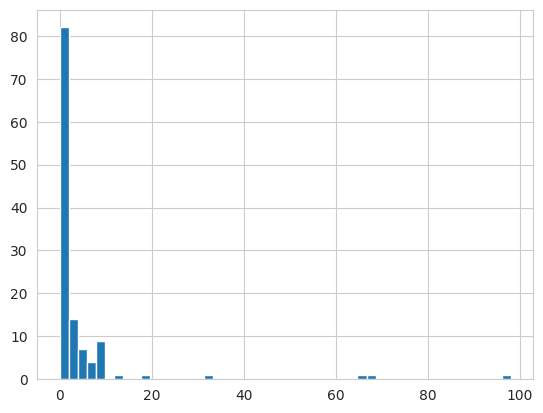

In [53]:
ass.Asymmetry.hist(bins=50)
plt.show()

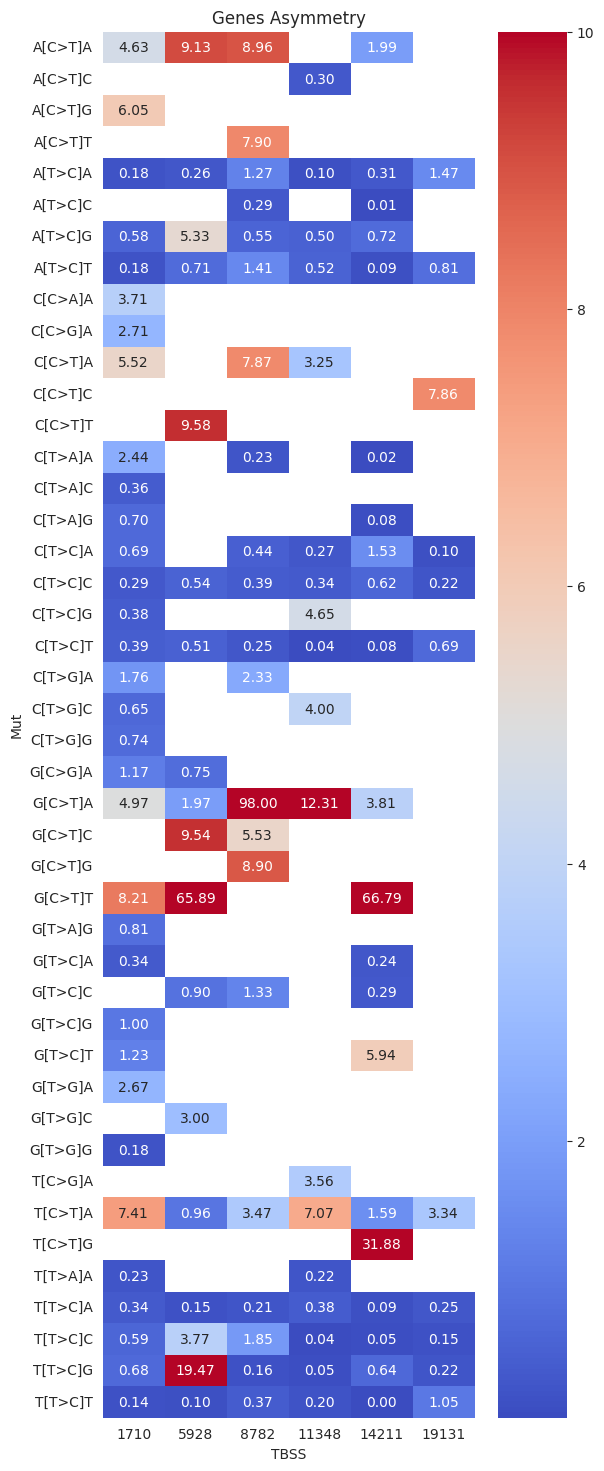

In [25]:
plt.figure(figsize=(6, 18))
plt.title("Genes Asymmetry")
sns.heatmap(ass.pivot(index="Mut", columns="TBSS", values="Asymmetry"), vmax=10, annot=True, cmap="coolwarm", fmt=".2f")
plt.savefig("../figures/HGT_Genes_Asymmetry.pdf")
plt.show()

#### Double-split

In [5]:
pmin, pmax = 5904, 12137
exp_muts12, exp_muts192 = get_exp_mut_freqs(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered[(muts_filtered.ref_pos >= pmin) & (muts_filtered.ref_pos <= pmax)]
print("Number of mutations:", obs_muts.shape[0])
ms12low_tsss = calculate_mutspec(obs_muts, exp_muts12, verbose=True)
ms192low_tsss = calculate_mutspec(obs_muts, exp_muts192, use_context=True, verbose=True)


pmin, pmax = 12337, 15887
exp_muts12, exp_muts192 = get_exp_mut_freqs(pmin, pmax)
# replace 'ref_pos' to "position"
obs_muts = muts_filtered[(muts_filtered.ref_pos >= pmin) & (muts_filtered.ref_pos <= pmax)]
print("Number of mutations:", obs_muts.shape[0])
ms12high_tsss = calculate_mutspec(obs_muts, exp_muts12, verbose=True)
ms192high_tsss = calculate_mutspec(obs_muts, exp_muts192, use_context=True, verbose=True)

Adjusted positions: 5904-12139
Number of mutations: 61206
Adjusted positions: 12337-15889
Number of mutations: 22121


WARNING! Substitution A[G>A]A is unexpected but observed, n=286
WARNING! Substitution C[G>A]C is unexpected but observed, n=635
WARNING! Substitution C[G>C]C is unexpected but observed, n=2
WARNING! Substitution C[G>T]C is unexpected but observed, n=8


In [9]:
ms192high_tsss = ms192high_tsss[(ms192high_tsss.ObsNum > 2) & (ms192high_tsss.ExpNum > 2)]
ms192low_tsss = ms192low_tsss[(ms192low_tsss.ObsNum > 2) & (ms192low_tsss.ExpNum > 2)]

ms192low_tsss["TSSS"] = "low"
ms192high_tsss["TSSS"] = "high"

ms192low_tsss["TSSS"] = "low"
ms192high_tsss["TSSS"] = "high"

ms192high_tsss.shape[0], ms192low_tsss.shape[0]

(78, 135)

In [19]:
gs192 = pd.concat([ms192low_tsss, ms192high_tsss])

gs192["Mut"] = gs192["Mut"].apply(rev_comp)  # to heavy chain

gs192["Cxt"] = gs192.Mut.str.get(0) + gs192.Mut.str.get(2) + gs192.Mut.str.get(-1)
gs192["MutBase"] = gs192.Mut.str.slice(2, 5)


In [57]:
asymmetry = pd.read_table(
    'https://raw.githubusercontent.com/mitoclub/mtdna-192component-mutspec-chordata/main/data/external/T-R_plot_allCpG.txt', 
    sep='\s', header=None, names=['Cxt','MutBase','T','R'])
asymmetry["Mut"] = asymmetry.Cxt.str.get(0) + '[' + asymmetry.MutBase + ']' + asymmetry.Cxt.str.get(2)

In [20]:
gs192_forvard = gs192[gs192.MutBase.isin(asymmetry.MutBase.unique())]

gs192_reverse = gs192[~gs192.MutBase.isin(asymmetry.MutBase.unique())]
gs192_reverse["Mut"] = gs192_reverse["Mut"].apply(rev_comp)

In [44]:
ass = gs192_forvard.merge(gs192_reverse, on=["TSSS", "Mut"])
ass["Asymmetry"] = ass.MutSpec_x / ass.MutSpec_y

In [45]:
ass[ass.Asymmetry > 10]

,Mut,ObsNum_x,ExpNum_x,RawMutSpec_x,MutSpec_x,TSSS,Cxt_x,MutBase_x,ObsNum_y,ExpNum_y,RawMutSpec_y,MutSpec_y,Cxt_y,MutBase_y,Asymmetry
4,G[C>T]T,1984,6,330.666667,0.075643,low,GCT,C>T,339,33,10.272727,0.002350,AGC,G>A,32.188791
5,C[C>T]T,771,3,257.000000,0.058791,low,CCT,C>T,2487,144,17.270833,0.003951,AGG,G>A,14.880579
17,G[C>T]G,1819,6,303.166667,0.069352,low,GCG,C>T,210,12,17.500000,0.004003,CGC,G>A,17.323810
18,C[C>T]G,526,4,131.500000,0.030082,low,CCG,C>T,498,39,12.769231,0.002921,CGG,G>A,10.298193
19,A[C>T]G,792,3,264.000000,0.060393,low,ACG,C>T,385,32,12.031250,0.002752,CGT,G>A,21.942857
33,C[C>T]C,836,4,209.000000,0.047811,low,CCC,C>T,1138,90,12.644444,0.002893,GGG,G>A,16.528998
36,C[C>A]C,16,3,5.333333,0.001220,low,CCC,C>A,44,90,0.488889,0.000112,GGG,G>T,10.909091
59,G[C>T]T,1888,4,472.000000,0.099369,high,GCT,C>T,50,14,3.571429,0.000752,AGC,G>A,132.160000


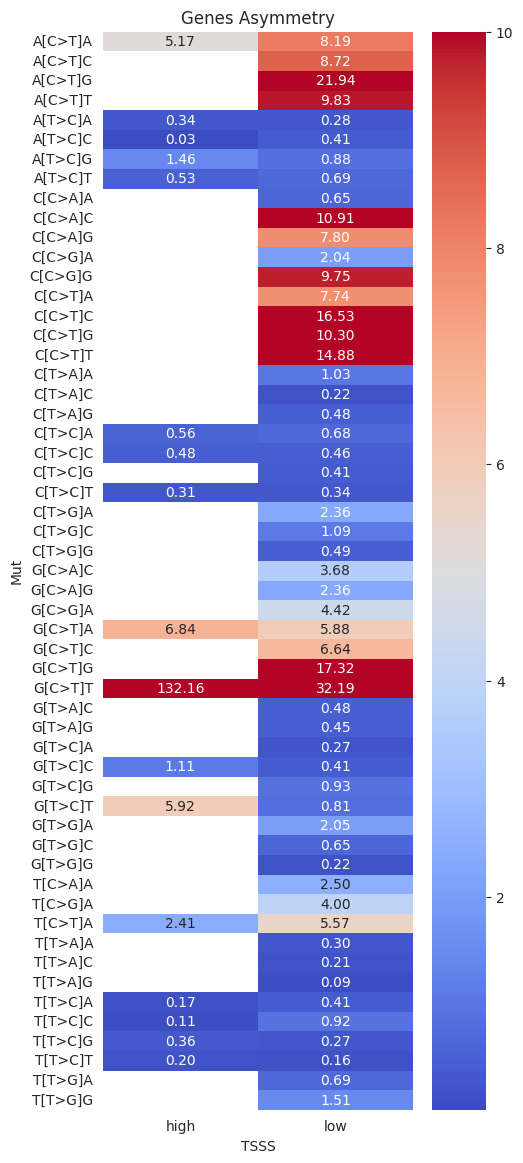

In [46]:
plt.figure(figsize=(5, 14))
plt.title("Genes Asymmetry")
sns.heatmap(ass.pivot(index="Mut", columns="TSSS", values="Asymmetry"), vmax=10, annot=True, cmap="coolwarm", fmt=".2f")
plt.savefig("../figures/HGT_Double-split_Asymmetry.pdf")
plt.show()

In [58]:
asymmetry = asymmetry.merge(ass[["TSSS", "Mut", "Asymmetry"]], on="Mut")
asymmetry["Asymmetry"] = np.log2(asymmetry["Asymmetry"])
asymmetry.head()

,Cxt,MutBase,T,R,Mut,TSSS,Asymmetry
0,ACA,C>T,-0.012015,-0.052744,A[C>T]A,low,3.034445
1,ACA,C>T,-0.012015,-0.052744,A[C>T]A,high,2.368834
2,ACC,C>T,0.028556,-0.069531,A[C>T]C,low,3.124390
3,ACG,C>T,0.071747,0.012317,A[C>T]G,low,4.455679
4,ACT,C>T,-0.088058,-0.074512,A[C>T]T,low,3.297612


In [60]:
asymmetry.rename(columns={"Asymmetry": "HGT_Asymmetry"}, inplace=True)

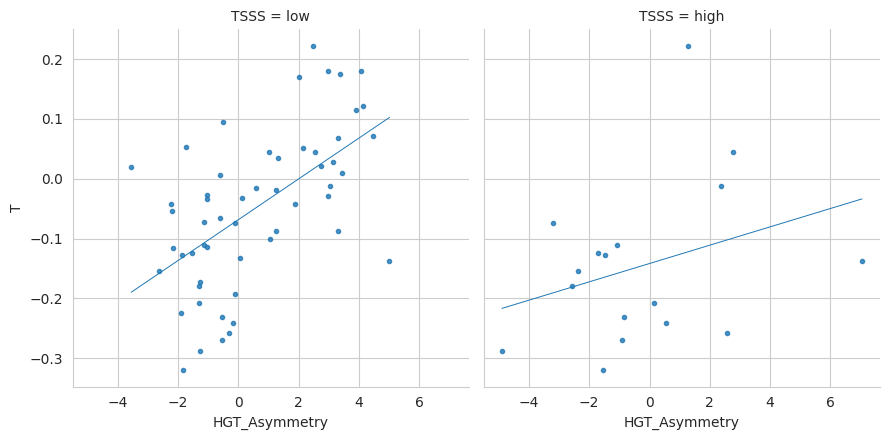

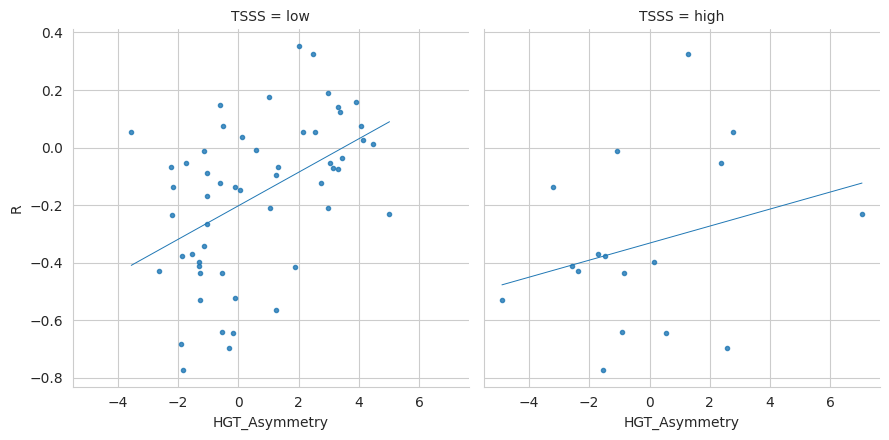

In [68]:
sns.lmplot(data=asymmetry, x="HGT_Asymmetry", y="T", col="TSSS", height=4.5, markers=".", ci=None, line_kws={"linewidth": 0.7})
# plt.suptitle("Seplyarskii vs HGT Asymmetry")
plt.show()

sns.lmplot(data=asymmetry, x="HGT_Asymmetry", y="R", col="TSSS", height=4.5, markers=".", ci=None, line_kws={"linewidth": 0.7})
# plt.suptitle("Seplyarskii vs HGT Asymmetry")
plt.show()

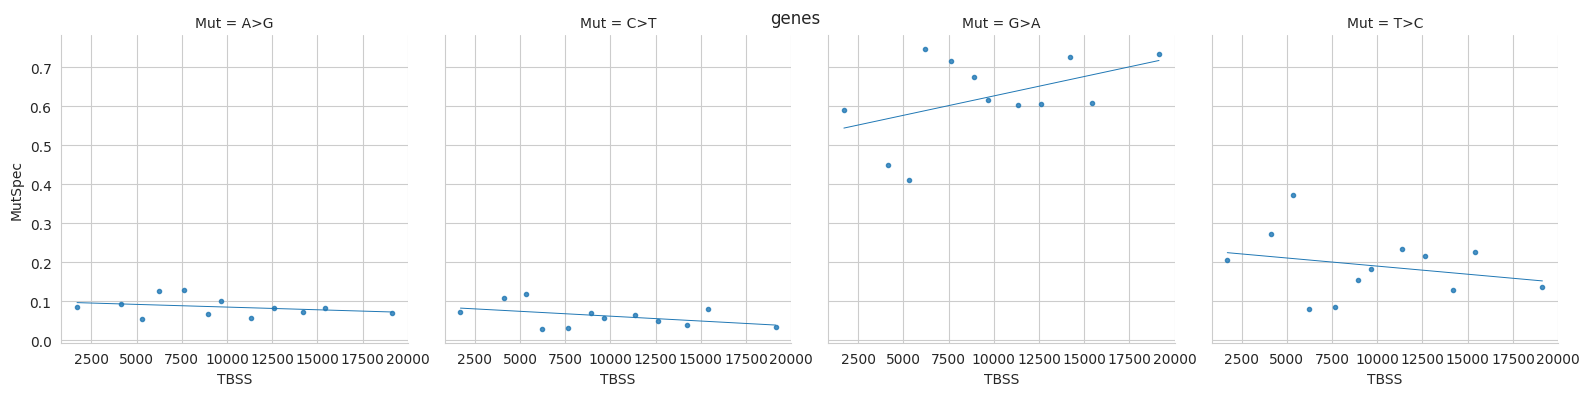

In [ ]:
sns.lmplot(data=full_ms12[full_ms12.Mut.isin("A>G C>T G>A T>C".split())], x="TBSS", y="MutSpec", col="Mut", height=4, markers=".", ci=None, line_kws={"linewidth": 0.7})
plt.suptitle("genes")
plt.savefig("../figures/GlobalHumanTree/mutspec_lmplot12genes.pdf")
plt.show()

In [81]:
# correlations
significan_sbs192 = dict()
for sbs, df in full_ms192.groupby("Mut"):
    res = scipy.stats.spearmanr(df.MutSpec, df.TBSS)
    if res.pvalue < 0.05 and df.shape[0] > 3:
        print(sbs, res)
    if res.correlation > 0.2 and df.shape[0] > 3:
        significan_sbs192[sbs] = res.correlation
pd.Series(significan_sbs192).sort_values(ascending=False)

G[A>G]C SpearmanrResult(correlation=0.7666666666666667, pvalue=0.01594401657897401)
G[A>G]T SpearmanrResult(correlation=-0.7380952380952381, pvalue=0.03655276105286081)
G[G>A]A SpearmanrResult(correlation=-0.7, pvalue=0.03576957497026169)
G[G>A]C SpearmanrResult(correlation=0.7166666666666667, pvalue=0.029818035695845287)


C[T>A]G    0.800000
G[A>G]C    0.766667
G[G>A]C    0.716667
C[T>A]A    0.607143
C[T>G]C    0.600000
C[G>C]C    0.485714
C[C>A]C    0.428571
A[G>A]A    0.404762
T[C>G]C    0.400000
T[C>G]A    0.400000
T[T>C]T    0.381818
A[C>T]G    0.380952
C[A>C]C    0.366667
A[T>C]G    0.357143
A[A>G]A    0.333333
C[C>A]A    0.309091
C[G>T]A    0.300000
T[G>C]C    0.300000
C[T>G]A    0.300000
G[C>A]C    0.257143
T[A>C]T    0.257143
G[T>C]C    0.216667
dtype: float64

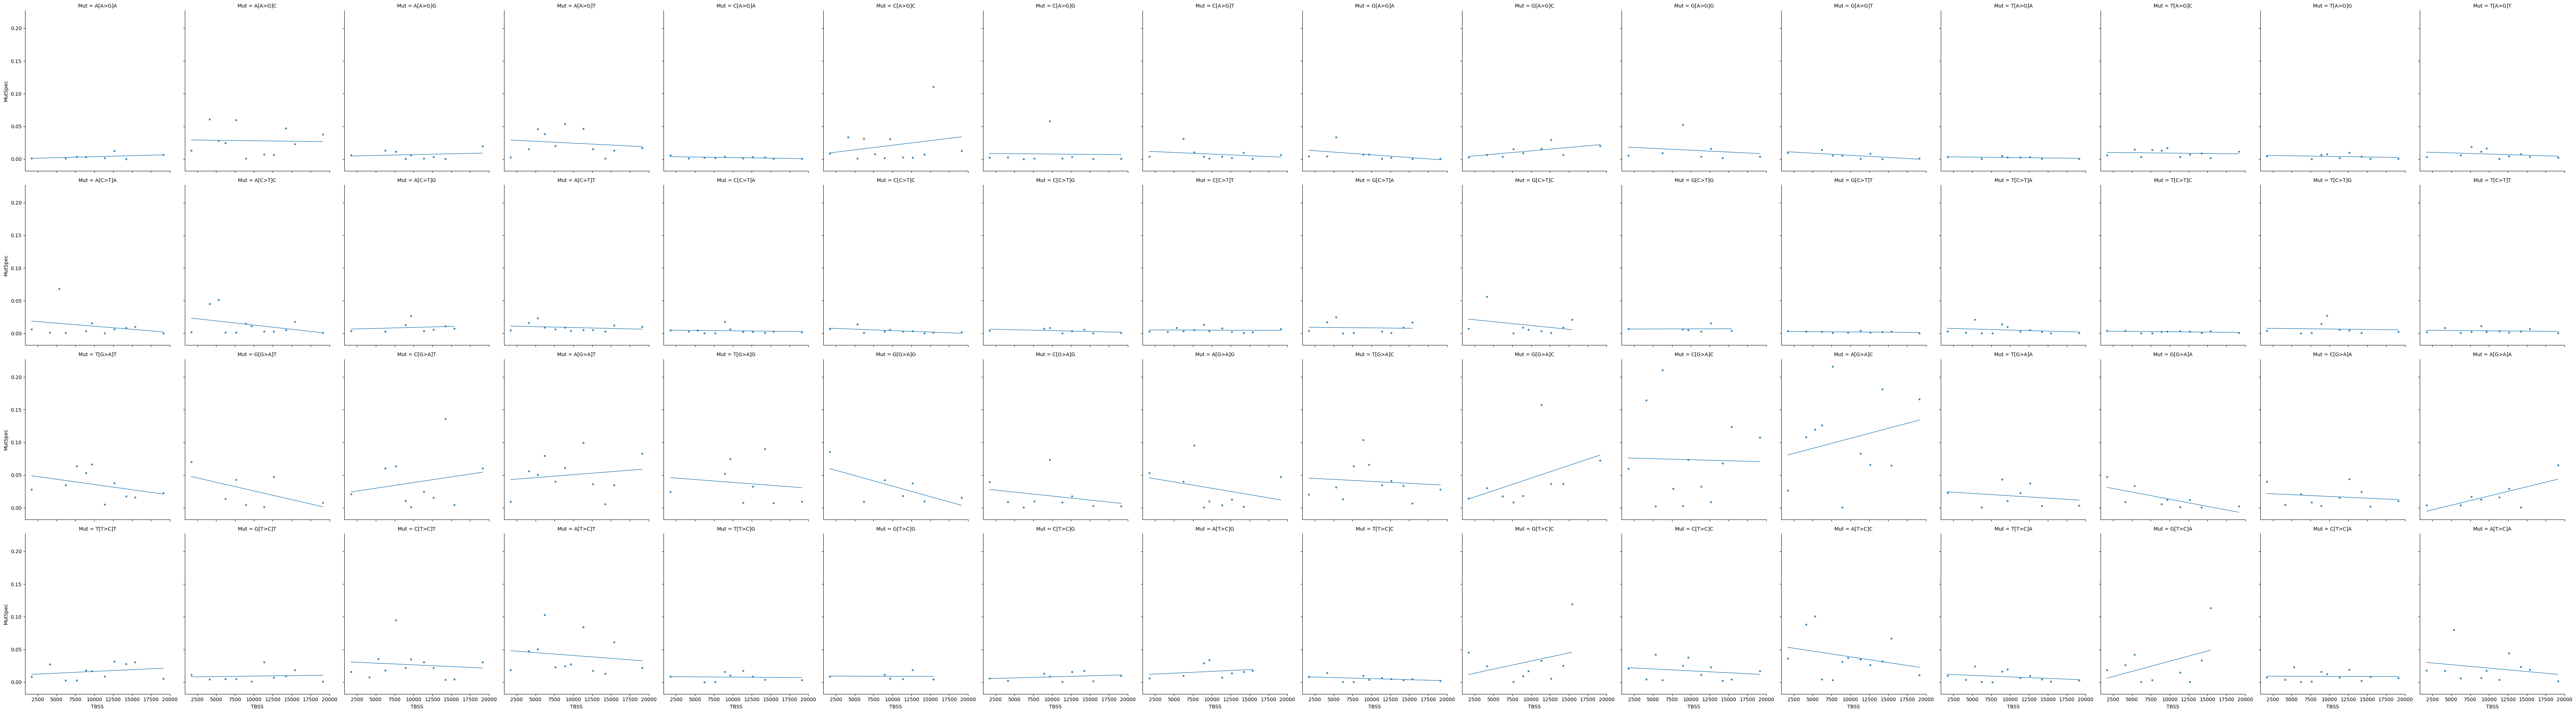

In [153]:
sns.lmplot(
    data=full_ms192,
    x="TBSS", y="MutSpec", col="Mut", col_wrap=16, aspect=.9, 
    col_order=[x for x in ordered_sbs192 if x[2:5] in {"C>T", "A>G", "G>A", "T>C"}],
    ci=None, markers=".", line_kws={"linewidth": 1}
)
plt.savefig("../figures/GlobalHumanTree/mutspec_lmplot192genes.pdf")
plt.show()

### intervals

In [154]:
_bounds = np.arange(3000, 16001, 1000)
print("bounds:", _bounds)
starts = _bounds[:-1]
ends = _bounds[1:]

gmutspecs192 = []
gmutspecs12 = []
for pmin, pmax in zip(starts, ends):
    exp_muts12, exp_muts192 = get_exp_mut_freqs(pmin, pmax)
    # exp_muts12 = {sbs: 1 for sbs in exp_muts12}
    # exp_muts192 = {sbs: 1 for sbs in exp_muts192}

    # replace 'ref_pos' to "position"
    obs_muts = muts_filtered_leaves[(muts_filtered_leaves.ref_pos >= pmin) & (muts_filtered_leaves.ref_pos <= pmax)]
    tbss_mean = obs_muts.TBSS.mean()

    print("Number of mutations:", obs_muts.shape[0])
    ms12 = calculate_mutspec(obs_muts, exp_muts12)
    ms192 = calculate_mutspec(obs_muts, exp_muts192, use_context=True)
    ms12 = ms12[ms12.ObsNum > 0]
    ms192 = ms192[ms192.ObsNum > 0]
    # # don't use unexpected mutations
    # ms192["RawMutSpec"] = np.where((ms192.ObsNum > 0) & (ms192.ExpFr == 0), 0, ms192.RawMutSpec)
    # ms192["MutSpec"] = ms192["RawMutSpec"] / ms192["RawMutSpec"].sum()
    # ms12 = ms12[ms12.ExpFr > 0]
    # ms192 = ms192[ms192.ExpFr > 0]

    ms192["TBSS"] = tbss_mean
    ms192["Interval"] = f"{pmin}-{pmax}"
    ms12["TBSS"] = tbss_mean
    ms12["Interval"] = f"{pmin}-{pmax}"

    gmutspecs12.append(ms12)
    gmutspecs192.append(ms192)

full_ms192 = pd.concat(gmutspecs192)
full_ms12 = pd.concat(gmutspecs12)

bounds: [ 3000  4000  5000  6000  7000  8000  9000 10000 11000 12000 13000 14000
 15000 16000]
Adjusted positions: 3307-4002
Number of mutations: 7531
Adjusted positions: 4000-5000
Number of mutations: 2810
Adjusted positions: 4998-6002
Number of mutations: 2530
Adjusted positions: 6000-7001
Number of mutations: 10944
Adjusted positions: 6999-8002
Number of mutations: 4482
Adjusted positions: 8000-9000
Number of mutations: 3977
Adjusted positions: 8998-9992
Number of mutations: 4745
Adjusted positions: 10059-11002
Number of mutations: 7380
Adjusted positions: 11000-12001
Number of mutations: 4459
Adjusted positions: 11999-13002
Number of mutations: 4086
Adjusted positions: 13000-14001
Number of mutations: 1661
Adjusted positions: 13999-15001
Number of mutations: 1676
Adjusted positions: 14999-15889
Number of mutations: 6339


WARNING! Substitution A[G>A]G is unexpected but observed, n=44
WARNING! Substitution A[T>C]C is unexpected but observed, n=50
WARNING! Substitution C[G>A]C is unexpected but observed, n=26
WARNING! Substitution C[G>A]G is unexpected but observed, n=33
WARNING! Substitution C[G>A]T is unexpected but observed, n=50
WARNING! Substitution C[T>A]T is unexpected but observed, n=2
WARNING! Substitution G[A>C]T is unexpected but observed, n=1
WARNING! Substitution G[G>A]A is unexpected but observed, n=9
WARNING! Substitution G[T>C]A is unexpected but observed, n=2
WARNING! Substitution G[T>C]C is unexpected but observed, n=19
WARNING! Substitution G[T>C]T is unexpected but observed, n=24
WARNING! Substitution T[C>A]G is unexpected but observed, n=3
WARNING! Substitution T[G>A]T is unexpected but observed, n=47
WARNING! Substitution C[G>A]A is unexpected but observed, n=8
WARNING! Substitution C[G>A]G is unexpected but observed, n=29
WARNING! Substitution C[G>A]T is unexpected but observed, n=3

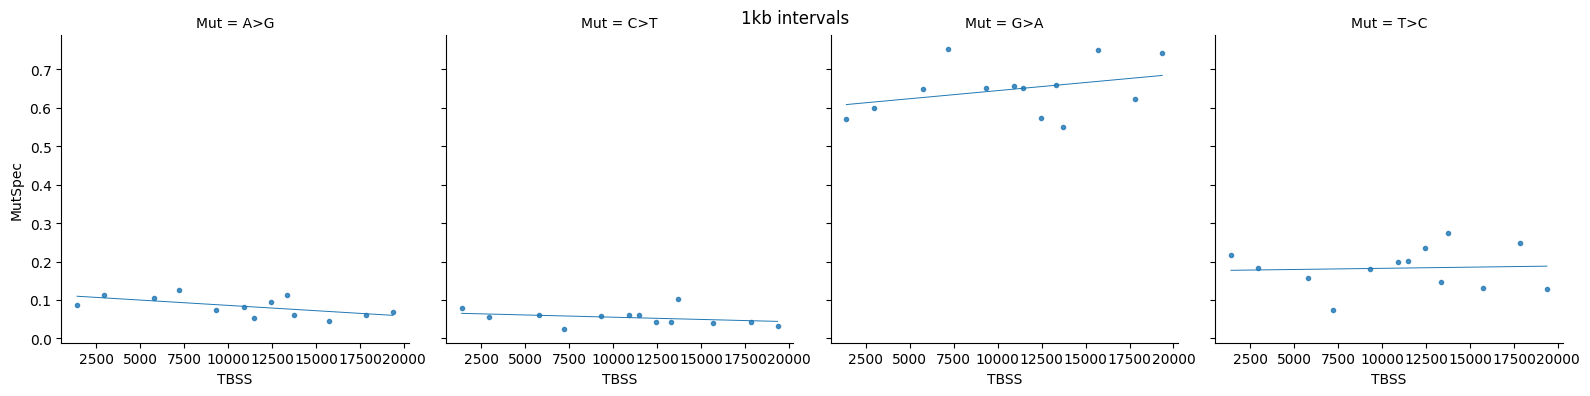

In [146]:
g = sns.lmplot(data=full_ms12[full_ms12.Mut.isin("A>G C>T G>A T>C".split())], x="TBSS", y="MutSpec", col="Mut", height=4, markers=".", ci=None, line_kws={"linewidth": 0.7})
plt.suptitle("1kb intervals")
plt.savefig("../figures/GlobalHumanTree/mutspec_lmplot12intervals.pdf")
plt.show()

In [109]:
# correlations
significan_sbs192 = dict()
for sbs, df in full_ms192.groupby("Mut"):
    res = scipy.stats.spearmanr(df.MutSpec, df.TBSS)
    if res.pvalue < 0.05 and df.shape[0] > 3:
        print(sbs, res)
    if res.correlation > 0.2 and df.shape[0] > 3:
        significan_sbs192[sbs] = res.correlation
pd.Series(significan_sbs192).sort_values(ascending=False)

C[T>A]A SpearmanrResult(correlation=0.7857142857142859, pvalue=0.03623846267982713)
G[G>A]A SpearmanrResult(correlation=-0.8214285714285715, pvalue=0.023448808345691505)
G[T>C]T SpearmanrResult(correlation=-0.8214285714285715, pvalue=0.023448808345691505)
T[A>C]T SpearmanrResult(correlation=0.8285714285714287, pvalue=0.04156268221574334)


T[A>C]T    0.828571
C[A>T]T    0.800000
C[T>A]T    0.800000
C[T>A]A    0.785714
A[C>T]G    0.657143
T[A>G]C    0.642857
C[T>A]G    0.600000
A[T>C]G    0.600000
C[T>G]A    0.600000
G[A>G]C    0.571429
C[T>C]G    0.571429
A[G>A]C    0.535714
T[T>C]T    0.500000
C[C>A]T    0.485714
A[G>A]A    0.428571
C[C>G]C    0.400000
G[C>T]G    0.400000
C[G>T]C    0.400000
T[C>G]A    0.400000
G[T>C]G    0.400000
C[G>C]C    0.400000
T[G>A]C    0.392857
A[A>G]C    0.392857
C[C>A]C    0.392857
G[G>A]C    0.392857
A[A>G]A    0.357143
C[A>T]A    0.321429
C[A>C]T    0.314286
T[C>A]T    0.314286
C[T>G]C    0.300000
C[G>T]A    0.300000
G[C>T]A    0.257143
A[T>C]C    0.250000
C[A>C]C    0.250000
C[T>C]T    0.214286
dtype: float64

In [ ]:
sns.lmplot(
    data=full_ms192[~(full_ms192.isin(["G[T>C]G", "G[C>T]G"]))],
    x="TBSS", y="MutSpec", col="Mut", col_wrap=16, aspect=.9, 
    col_order=[x for x in ordered_sbs192 if x[2:5] in {"C>T", "A>G", "G>A", "T>C"}],
    ci=None, markers=".", line_kws={"linewidth": 1}
)
plt.savefig("../figures/GlobalHumanTree/mutspec_lmplot192intervals.pdf")
plt.show()

## Gradients confirmation

### ALL

In [160]:
muts_filtered_all = mut[
    (mut.ancestor.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (mut.descendant.str.contains("[acgt]{2}[ACGT][acgt]{2}")) &
    (~mut.gene_info.str.contains("ND6")) &
    (mut.apply(lambda x: sum([x != y for x, y in zip(x.ancestor, x.descendant)]) == 1, axis=1)) &
    (mut.is_leaf == 1)
]
print("Mut numbers:", mut.shape[0])
print("After filtration:", muts_filtered_all.shape[0])

muts_filtered_all["TBSS"] = muts_filtered_all.ref_pos.map(Ref.set_index("Pos").TBSS.to_dict())
muts_filtered_all["Label"] = 0

Mut numbers: 577276
After filtration: 280187


In [163]:
gmutspecs12 = []
for pmin in tqdm.tqdm(range(6000, 15589)):
    pmax = pmin + 300
    exp_muts12, _ = get_exp_mut_freqs(pmin, pmax, Ref, "all", verbose=False)
    if not exp_muts12:
        continue

    # replace 'ref_pos' to "position"
    obs_muts = muts_filtered_all[(muts_filtered_all.ref_pos >= pmin) & (muts_filtered_all.ref_pos <= pmax)]
    if not len(exp_muts12):
        continue
    tbss_mean = obs_muts.TBSS.mean()

    ms12 = calculate_mutspec(obs_muts, exp_muts12)
    ms12 = ms12[ms12.ObsNum > 0]

    ms12["Pos"] = pmin
    ms12["TBSS"] = tbss_mean
    ms12["Interval"] = f"{pmin}-{pmax}"

    gmutspecs12.append(ms12)

full_ms12 = pd.concat(gmutspecs12, ignore_index=True)

100%|██████████| 9589/9589 [01:48<00:00, 88.32it/s] 


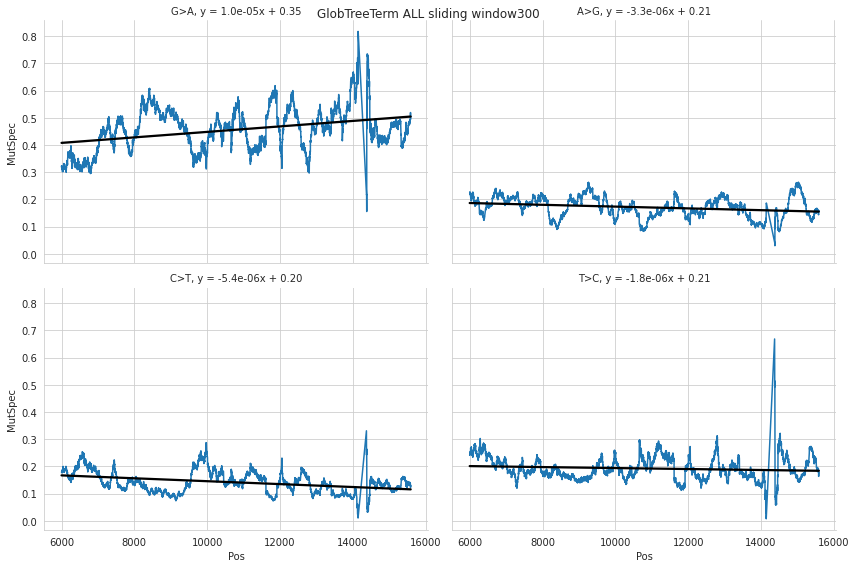

In [174]:
used_sbs = "G>A A>G C>T T>C".split()
g = sns.FacetGrid(full_ms12[full_ms12.Mut.isin(used_sbs)], col="Mut", col_wrap=2, size=4, aspect=1.5, col_order=used_sbs)
g.map(sns.lineplot, "Pos", "MutSpec")
g.map(sns.regplot, "Pos", "MutSpec", scatter=False, color="black")
plt.suptitle("GlobTreeTerm ALL sliding window300")
for sbs in used_sbs:
    lr_res = scipy.stats.linregress(full_ms12[full_ms12.Mut == sbs].Pos.values, full_ms12[full_ms12.Mut == sbs].MutSpec.values)
    ax = g.axes_dict[sbs]
    ax.title.set_text(f"{sbs}, y = {lr_res.slope:.1e}x + {lr_res.intercept:.2f}")
# plt.savefig("../figures/GlobalHumanTree/.pdf")
plt.show()

In [166]:
for sbs in used_sbs:
    lr_res = scipy.stats.linregress(full_ms12[full_ms12.Mut == sbs].Pos.values, full_ms12[full_ms12.Mut == sbs].MutSpec.values)
    print(lr_res)

LinregressResult(slope=1.0096872926574648e-05, intercept=0.3471531882639337, rvalue=0.35472441634064483, pvalue=1.0163056746392196e-275, stderr=2.7506338318296644e-07, intercept_stderr=0.0030414263829762894)
LinregressResult(slope=-3.2894579084424216e-06, intercept=0.2063079257238771, rvalue=-0.23758184703086396, pvalue=2.737588795635212e-120, stderr=1.3900599666207283e-07, intercept_stderr=0.0015370148536227382)
LinregressResult(slope=-5.35734990910938e-06, intercept=0.19940701644162792, rvalue=-0.3688440457773016, pvalue=1.5451619074458354e-299, stderr=1.3956002631494472e-07, intercept_stderr=0.001542987793424513)
LinregressResult(slope=-1.7959226063635877e-06, intercept=0.21213054464645953, rvalue=-0.11845315014367988, pvalue=1.334989506146508e-30, stderr=1.5562561453771385e-07, intercept_stderr=0.0017206103346095948)


### SYN

In [46]:
gmutspecs12 = []
for pmin in tqdm.tqdm(range(6000, 15589)):
    pmax = pmin + 300
    exp_muts12, _ = get_exp_mut_freqs(pmin, pmax, verbose=False)
    if not exp_muts12:
        continue

    # replace 'ref_pos' to "position"
    obs_muts = muts_filtered_leaves[(muts_filtered_leaves.ref_pos >= pmin) & (muts_filtered_leaves.ref_pos <= pmax)]
    if not len(exp_muts12):
        continue
    tbss_mean = obs_muts.TBSS.mean()

    ms12 = calculate_mutspec(obs_muts, exp_muts12)
    ms12 = ms12[ms12.ObsNum > 0]

    ms12["Pos"] = pmin
    ms12["TBSS"] = tbss_mean
    ms12["Interval"] = f"{pmin}-{pmax}"

    gmutspecs12.append(ms12)

full_ms12 = pd.concat(gmutspecs12, ignore_index=True)

100%|██████████| 9589/9589 [01:05<00:00, 146.36it/s]


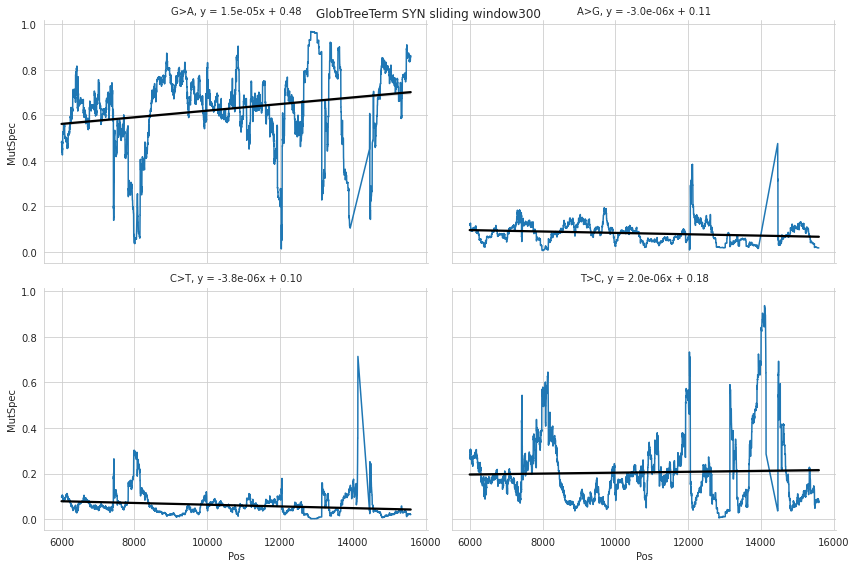

In [149]:
used_sbs = "G>A A>G C>T T>C".split()
g = sns.FacetGrid(full_ms12[full_ms12.Mut.isin(used_sbs)], col="Mut", col_wrap=2, size=4, aspect=1.5, col_order=used_sbs)
g.map(sns.lineplot, "Pos", "MutSpec")
g.map(sns.regplot, "Pos", "MutSpec", scatter=False, color="black")
plt.suptitle("GlobTreeTerm SYN sliding window300")
for sbs in used_sbs:
    lr_res = scipy.stats.linregress(full_ms12[full_ms12.Mut == sbs].Pos.values, full_ms12[full_ms12.Mut == sbs].MutSpec.values)
    ax = g.axes_dict[sbs]
    ax.title.set_text(f"{sbs}, y = {lr_res.slope:.1e}x + {lr_res.intercept:.2f}")
# plt.savefig("../figures/GlobalHumanTree/.pdf")
plt.show()

In [146]:
for sbs in used_sbs:
    lr_res = scipy.stats.linregress(full_ms12[full_ms12.Mut == sbs].Pos.values, full_ms12[full_ms12.Mut == sbs].MutSpec.values)
    print(lr_res)

LinregressResult(slope=1.4553519662902214e-05, intercept=0.47500346341242716, rvalue=0.22478603491809668, pvalue=6.825053224613588e-104, stderr=6.636689598613922e-07, intercept_stderr=0.007264479597992119)
LinregressResult(slope=-3.041173106017809e-06, intercept=0.11428867766818887, rvalue=-0.18431602324252555, pvalue=7.283383949510599e-70, stderr=1.7063055863687068e-07, intercept_stderr=0.001867646884858777)
LinregressResult(slope=-3.788874089268182e-06, intercept=0.10109944397757303, rvalue=-0.22016328307406344, pvalue=3.5332752059686347e-102, stderr=1.743463282307923e-07, intercept_stderr=0.0019212775253160093)
LinregressResult(slope=1.980868618048509e-06, intercept=0.18392189107608337, rvalue=0.03448712190040959, pvalue=0.000895264599305362, stderr=5.961794592316248e-07, intercept_stderr=0.006569832629686964)
